# Final MVP - Datada Team - Vietnam Datathon Contest

## Time Series Analysis

### **Sales data area**

Sales data are collected every month from 2022-2023, the files follow the format

`TT T<month>-<year>.xlsx`

Where

`<month>` represents the month number (from 01 to 12)

`<year>` represents year number (2022 or 2023).

For example, the file “TT T01-2022.xlss” represents the sales data for January 2022

Each file includes the following data fields:

- `month`: month in year
- `week`: week in year
- `site`: warehouse/store ID
- `branch_id`: the branch ID
- `channel_id`: code of distribution channel
- `distribution_channel_code`: Determine the distribution channel’s unique code.
- `sold_quantity`: the number of products or units that have been sole (số lượng tiêu thụ)
- `cost_price`: the direct costs associated with producing or purchasing the goods that a company sells during a specific accounting period (Trị giá tiêu thụ -  giá vốn)
- `net_price`: the final price of a product (trị giá tiêu thị - giá sau chiết khấu)
- `customer_id`: the customer ID
- `product_id`: the product ID

### Import neccessary libraries

In [1]:
import pandas as pd
import numpy as np
import glob
import os

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from keras.models import Sequential
from keras.layers import Dense, LSTM

import warnings
warnings.filterwarnings('ignore')

### Merge multiple files `TT T<month>-<year>.xlsx` into one

In [2]:
if os.path.isfile('../clean_data/sales.csv'):
    sales_data = pd.read_csv('../clean_data/sales.csv')
else:
    # Set the path to your dataset files
    sales_files = glob.glob("../data/Sales_mentor/TT T*.xlsx")

    # Initialize an empty DataFrame to store the sales data
    sales_data = pd.DataFrame()

    # Read each sales file and concatenate them into a single DataFrame
    for file in sales_files:
        df = pd.read_excel(file)
        sales_data = pd.concat([sales_data, df], ignore_index=True)

In [3]:
sales_data

Unnamed: 0    month    week  site  branch_id channel_id  \
0                 0  2022001  202201  1621       1600       CHTT   
1                 1  2022001  202204  1113       1100       CHTT   
2                 2  2022001  202204  1105       1100       CHTT   
3                 3  2022001  202201  1100       1100       TGPP   
4                 4  2022001  202202  1124       1100       CHTT   
...             ...      ...     ...   ...        ...        ...   
2495918     2495918  2022012  202251  1100       1100       TGPP   
2495919     2495919  2022012  202252  1103       1100       CHTT   
2495920     2495920  2022012  202249  1104       1100       CHTT   
2495921     2495921  2022012  202252  1413       1400       CHTT   
2495922     2495922  2022012  202248  1100       1100       TGPP   

        distribution_channel distribution_channel_code  sold_quantity  \
0                     Bán lẻ                        FP              1   
1                     Bán lẻ                        FP              1   
2                     Bán lẻ                        FP              1   
3                  Phát sinh                       ZF2              1   
4                     Bán lẻ                        FP              2   
...                      ...                       ...            ...   
2495918            Phát sinh                       ZF2              5   
2495919               Bán lẻ                        FP              1   
2495920               Bán lẻ                        FP              1   
2495921               Bán lẻ                        FP              1   
2495922            Phát sinh                       ZF2              3   

         cost_price  net_price customer_id  \
0            190400     280000   299feddd6   
1            238000     350000   a0c1d36b9   
2             98600     145000   3dd717588   
3            645320     692770   1a5f09a4b   
4             47600      70000   af943870d   
...             ...        ...         ...   
2495918      320465     367594   f445f6b3a   
2495919      343833     506000   8a6174afa   
2495920      353847     520000   421de55a1   
2495921      343833     506000   9d665de8f   
2495922      600873     671563   2dd2e63e8   

                                    product_id  
0        e601c53ee1374c3093c75ec063f5d0c6HOG33  
1        dbaca16058bb45c885684dc2d4df87bcDEN41  
2        93f3d133edd842ea8e9aff4a9c7642ccDEN38  
3        433e13a4293d4f4694ff5f7a279ad95dDEN42  
4        96109022ecc24ec89504a79025d7f524TRG25  
...                                        ...  
2495918  521844b57252468082e29f9b3283d215DEN39  
2495919  271e7b67bb914be1a195ccfd18c54857DEN36  
2495920  aba4fcd6bbe14a6d9acff57459fb4b2cTRG35  
2495921  a7de16adba314df4a00201f5f7fc9d3dDEN38  
2495922  3d266b03be4241658a3202e3f7a8a220DEN41  

[2495923 rows x 13 columns]

In [4]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2495923 entries, 0 to 2495922
Data columns (total 13 columns):
 #   Column                     Dtype 
---  ------                     ----- 
 0   Unnamed: 0                 int64 
 1   month                      int64 
 2   week                       int64 
 3   site                       int64 
 4   branch_id                  int64 
 5   channel_id                 object
 6   distribution_channel       object
 7   distribution_channel_code  object
 8   sold_quantity              int64 
 9   cost_price                 int64 
 10  net_price                  int64 
 11  customer_id                object
 12  product_id                 object
dtypes: int64(8), object(5)
memory usage: 247.6+ MB


In [5]:
sales_data.describe()

Unnamed: 0         month          week          site     branch_id  \
count  2.495923e+06  2.495923e+06  2.495923e+06  2.495923e+06  2.495923e+06   
mean   1.247961e+06  2.022310e+06  2.022528e+05  1.283836e+03  1.265679e+03   
std    7.205111e+05  4.588168e+02  4.383416e+01  2.149671e+02  2.201048e+02   
min    0.000000e+00  2.022001e+06  2.021530e+05  1.100000e+03  1.100000e+03   
25%    6.239805e+05  2.022005e+06  2.022180e+05  1.118000e+03  1.100000e+03   
50%    1.247961e+06  2.022009e+06  2.022370e+05  1.200000e+03  1.200000e+03   
75%    1.871942e+06  2.023001e+06  2.023030e+05  1.503000e+03  1.500000e+03   
max    2.495922e+06  2.023007e+06  2.023520e+05  2.001000e+03  2.000000e+03   

       sold_quantity    cost_price     net_price  
count   2.495923e+06  2.495923e+06  2.495923e+06  
mean    1.409085e+00  3.055363e+05  3.994306e+05  
std     4.415640e+00  6.230018e+05  7.160275e+05  
min    -2.150000e+02 -2.980644e+07 -3.141630e+07  
25%     1.000000e+00  1.190000e+05  1.600000e+05  
50%     1.000000e+00  2.069680e+05  2.900000e+05  
75%     1.000000e+00  3.271420e+05  4.600000e+05  
max     5.000000e+03  2.210000e+08  2.730000e+08

In [6]:
missing_values = sales_data.isnull().sum()
missing_values

Unnamed: 0                   0
month                        0
week                         0
site                         0
branch_id                    0
channel_id                   0
distribution_channel         0
distribution_channel_code    0
sold_quantity                0
cost_price                   0
net_price                    0
customer_id                  1
product_id                   0
dtype: int64

In [7]:
duplicate_rows = sales_data.duplicated()

# Print the number of duplicate rows
print(f'Number of duplicate rows: {duplicate_rows.sum()}')

Number of duplicate rows: 0


In [8]:
# Delete duplicate rows
sales_data = sales_data.drop_duplicates()

# Print the number of rows after deleting duplicates
print(f'Number of rows after deleting duplicates: {len(sales_data)}')

Number of rows after deleting duplicates: 2495923


### **Some EDA**

In [9]:
for col in sales_data.dtypes.index:
    # Check data type of column
    if sales_data[col].dtype == 'object':
        print("\nTOTAL UNIQUE VALUE IN THE COL {}".format(col),sales_data[col].nunique())


TOTAL UNIQUE VALUE IN THE COL channel_id 5

TOTAL UNIQUE VALUE IN THE COL distribution_channel 7

TOTAL UNIQUE VALUE IN THE COL distribution_channel_code 9

TOTAL UNIQUE VALUE IN THE COL customer_id 1191

TOTAL UNIQUE VALUE IN THE COL product_id 35502


In [10]:
sales_data['channel_id'] = sales_data['channel_id'].replace({'Online': 'ONLINE'})


In [11]:
sales_data['total_sales'] = sales_data['sold_quantity'] * sales_data['net_price']

# Calculate total sales for each branch/warehouse
total_sales_per_channel = sales_data.groupby(['channel_id', 'month', 'week'])['total_sales'].sum().reset_index()

# Calculate total sales for each product
total_sales_per_distribution_channel = sales_data.groupby(['distribution_channel', 'month', 'week'])['total_sales'].sum().reset_index()

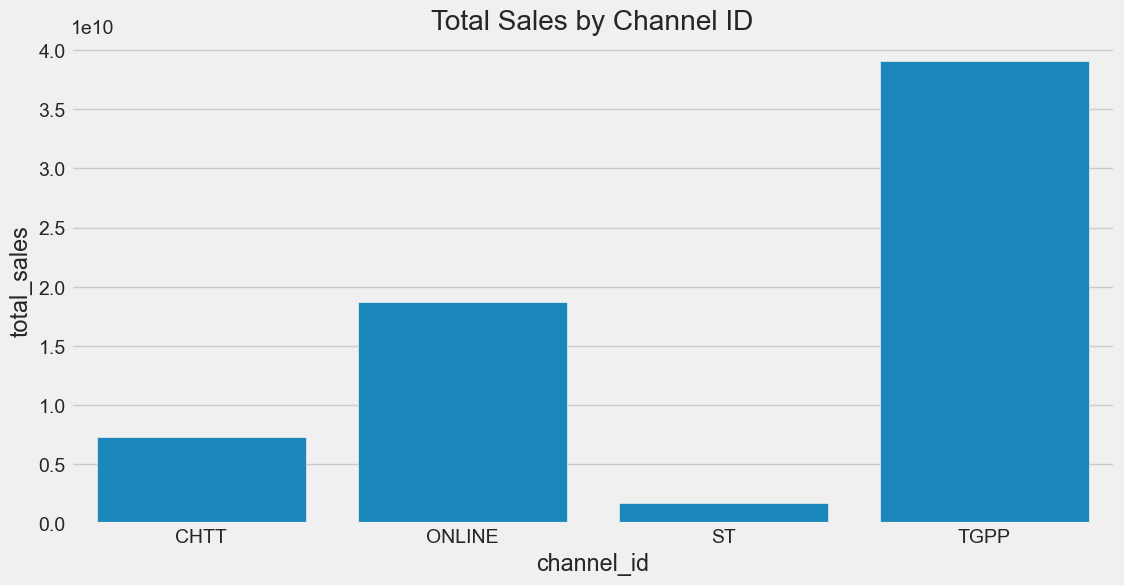

In [12]:
# Visualize the results
plt.figure(figsize=(12, 6))
sns.barplot(x='channel_id', y='total_sales', data=total_sales_per_channel, ci=None)
plt.title('Total Sales by Channel ID')
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='distribution_channel', y='total_sales', data=total_sales_per_distribution_channel, ci=None)
plt.title('Total Sales by Distribution Channel')
plt.show()

### **Preprocessing**

In [13]:
# Assuming 'df' is your DataFrame
sales_data['year'] = sales_data['month'].astype(str).str[:4].astype(int)
sales_data['month'] = sales_data['month'].astype(str).str[-2:].astype(int)
sales_data['week'] = sales_data['week'].astype(str).str[-2:].astype(int)  # Extract the last two digits to get the week

# Now 'year', 'month', and 'week' are extracted as separate columns

# Display the modified DataFrame
sales_data[['year', 'month', 'week']]

year  month  week
0        2022      1     1
1        2022      1     4
2        2022      1     4
3        2022      1     1
4        2022      1     2
...       ...    ...   ...
2495918  2022     12    51
2495919  2022     12    52
2495920  2022     12    49
2495921  2022     12    52
2495922  2022     12    48

[2495923 rows x 3 columns]

Let's convert `year` and `week of year` to `date`

In [14]:
dates = sales_data.year*100+sales_data.week
sales_data['date'] = pd.to_datetime(dates.astype(str) + '0', format='%Y%W%w')
sales_data = sales_data.drop(['year', 'month', 'week'], axis=1)
sales_data['date']

0         2022-01-09
1         2022-01-30
2         2022-01-30
3         2022-01-09
4         2022-01-16
             ...    
2495918   2022-12-25
2495919   2023-01-01
2495920   2022-12-11
2495921   2023-01-01
2495922   2022-12-04
Name: date, Length: 2495923, dtype: datetime64[ns]

In [15]:
# Calculate total cost for each transaction
sales_data['total_cost'] = sales_data['sold_quantity'] * sales_data['cost_price']

In [16]:
# Aggregate total cost over time

total_cost_over_time = sales_data.groupby(['date'])['total_cost'].sum().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(total_cost_over_time['date'], total_cost_over_time['total_cost'], marker='o')
plt.title('Total Cost Over Time')
plt.xlabel('Date')
plt.ylabel('Total Cost')
plt.grid(True)
plt.show()

In [17]:
# Calculate profit for each transaction
sales_data['profit'] = (sales_data['sold_quantity'] >= 0).mul(sales_data['total_sales']) - sales_data['total_cost']

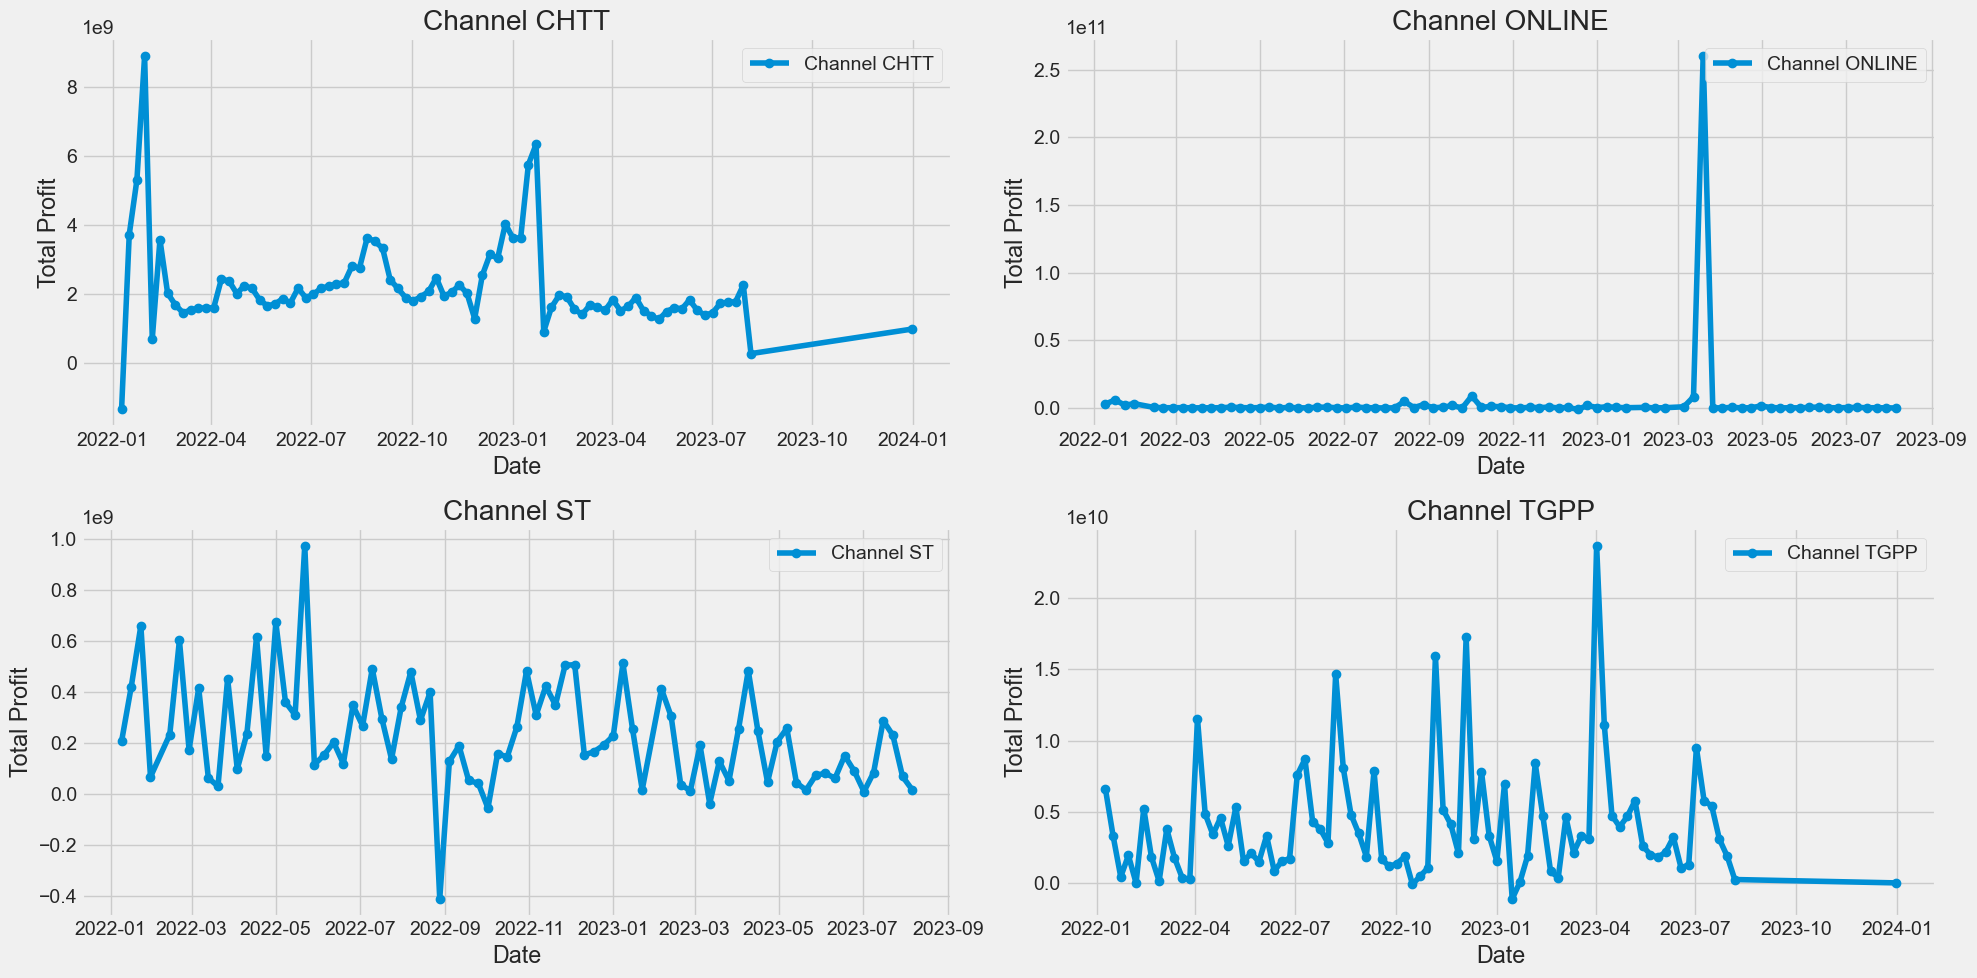

In [18]:
total_profit_over_time = sales_data.groupby(['date', 'channel_id'])['profit'].sum().reset_index()

fig, axs = plt.subplots(2, 2, figsize=(20, 10))
axs = axs.ravel()

# Plot a line for each channel_id
for i, channel in enumerate(total_profit_over_time['channel_id'].unique()):
    data = total_profit_over_time[total_profit_over_time['channel_id'] == channel]
    axs[i].plot(data['date'], data['profit'], marker='o', label=f'Channel {channel}')
    axs[i].set_title(f'Channel {channel}')
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('Total Profit')
    axs[i].grid(True)
    axs[i].legend()

plt.tight_layout()
plt.show()

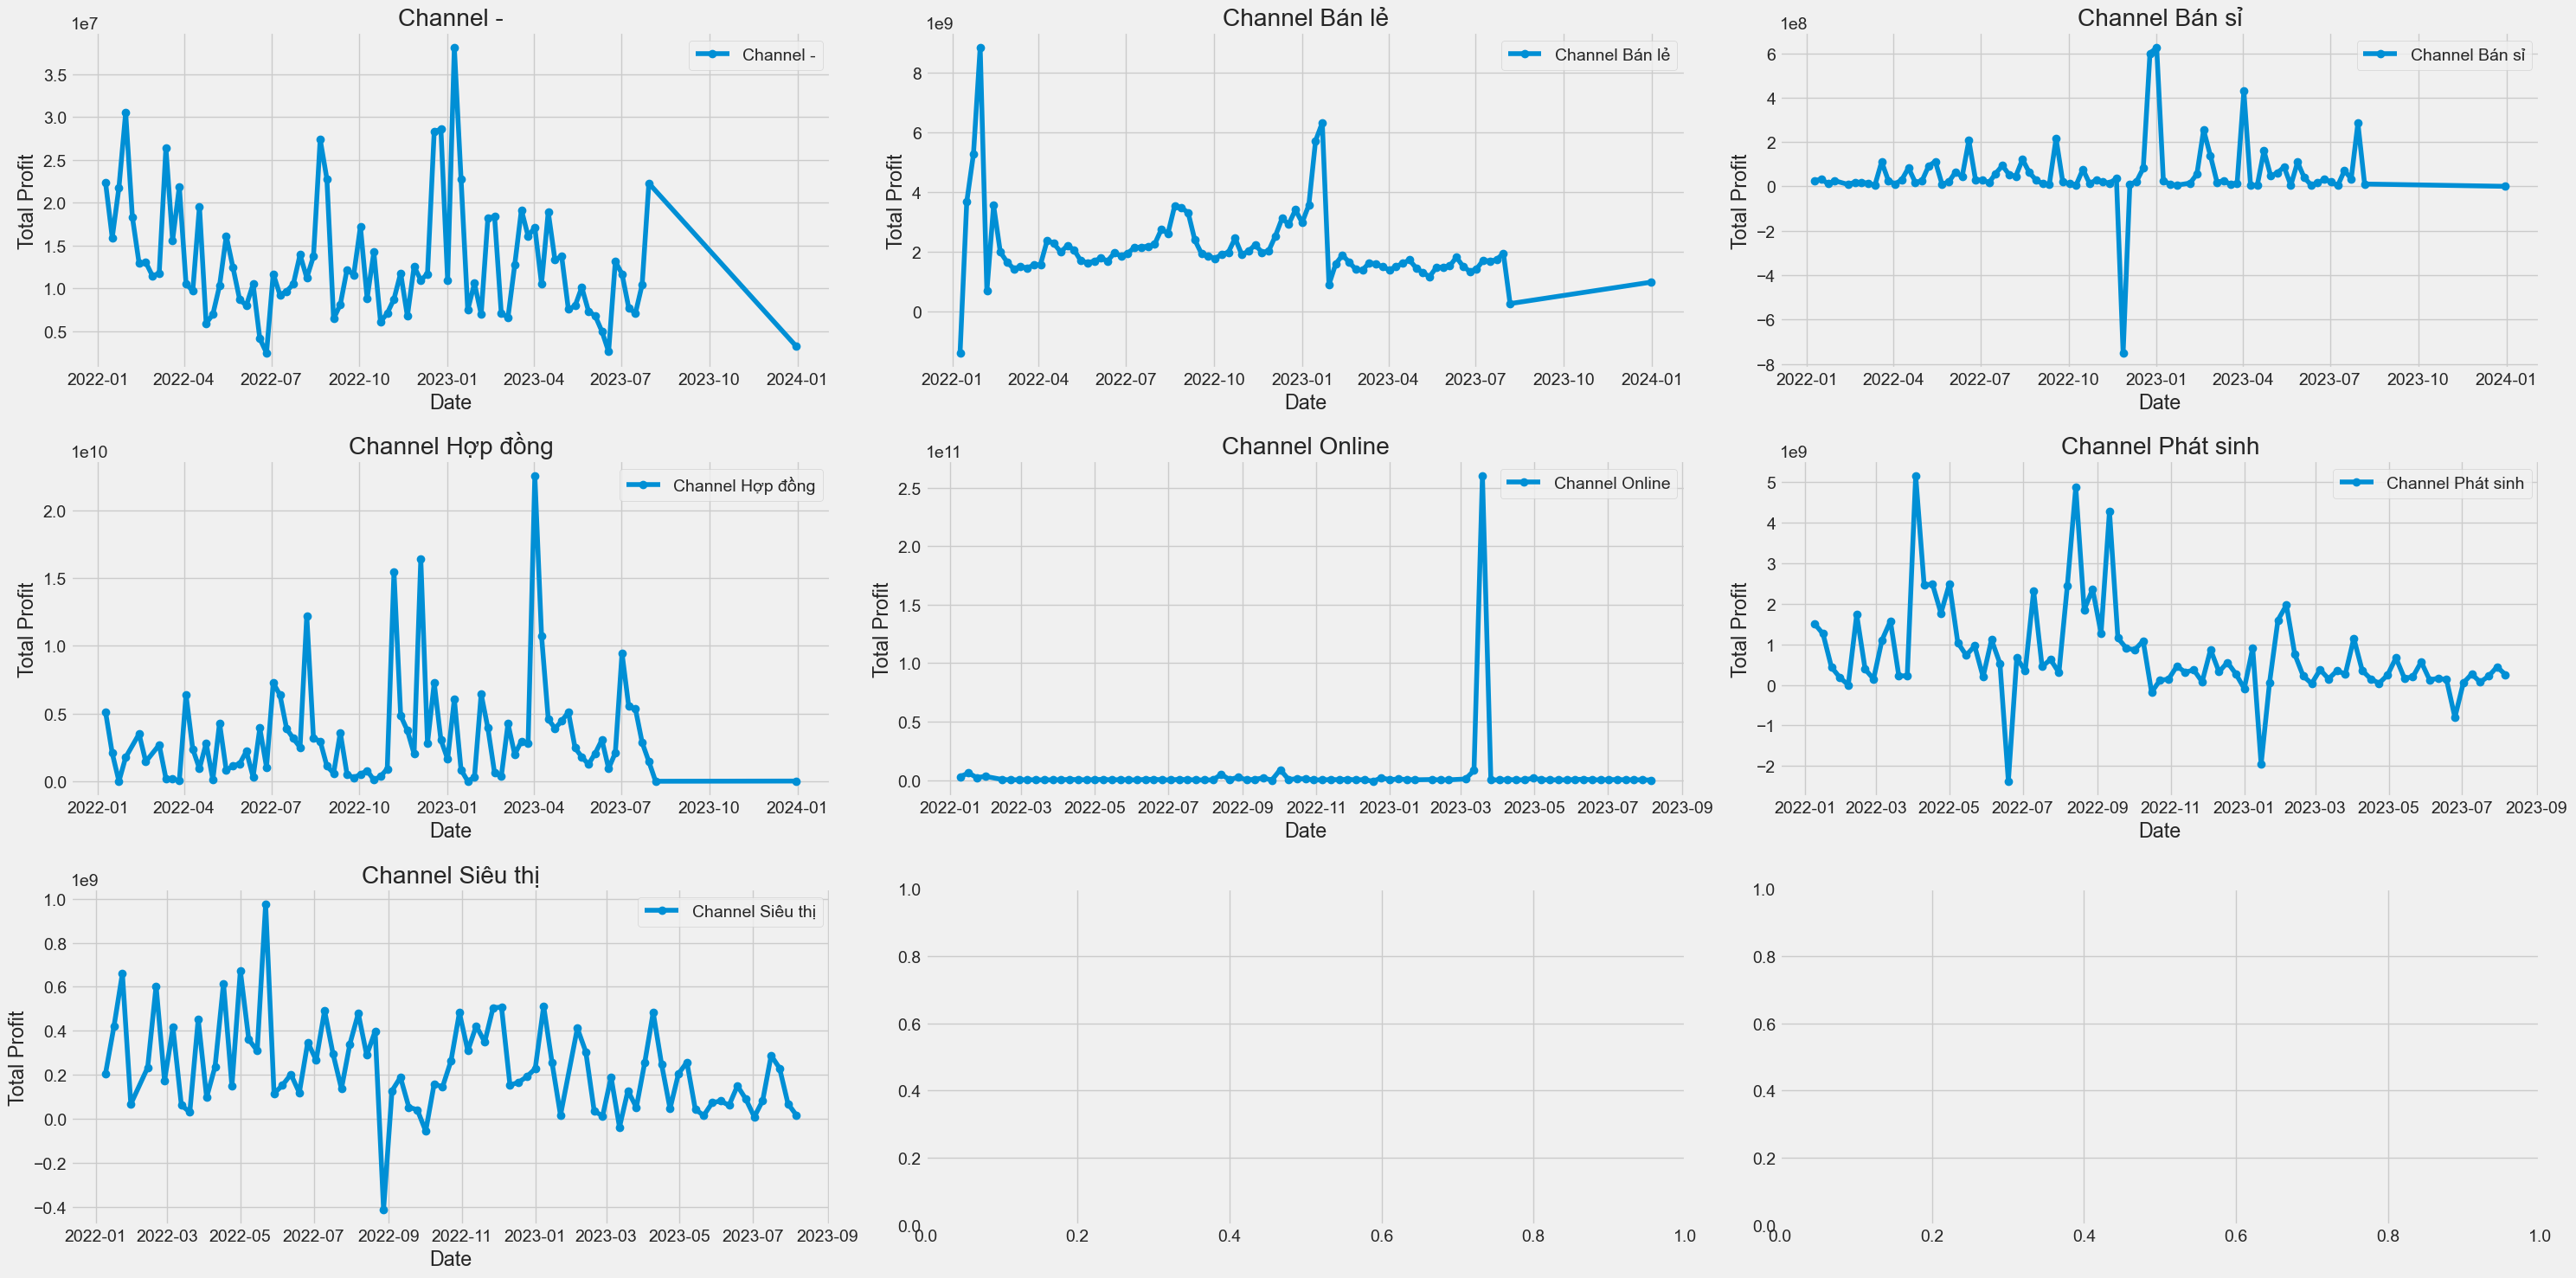

In [19]:
total_profit_over_time = sales_data.groupby(['date', 'distribution_channel'])['profit'].sum().reset_index()

fig, axs = plt.subplots(3, 3, figsize=(30, 15))
axs = axs.ravel()

# Plot a line for each distribution_channel
for i, channel in enumerate(total_profit_over_time['distribution_channel'].unique()):
    data = total_profit_over_time[total_profit_over_time['distribution_channel'] == channel]
    axs[i].plot(data['date'], data['profit'], marker='o', label=f'Channel {channel}')
    axs[i].set_title(f'Channel {channel}')
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('Total Profit')
    axs[i].grid(True)
    axs[i].legend()

plt.tight_layout()
plt.show()

### **Data Modeling**

In [20]:
total_profit_over_time = sales_data.groupby(['date', 'channel_id'])['profit'].sum().reset_index()

#### **ARIMA Model**

Channel CHTT Test Mean Squared Error: 0.013371418943065797
Channel ONLINE Test Mean Squared Error: 0.024478203893407987
Channel ST Test Mean Squared Error: 0.026958679296170126
Channel TGPP Test Mean Squared Error: 0.0431851723171442


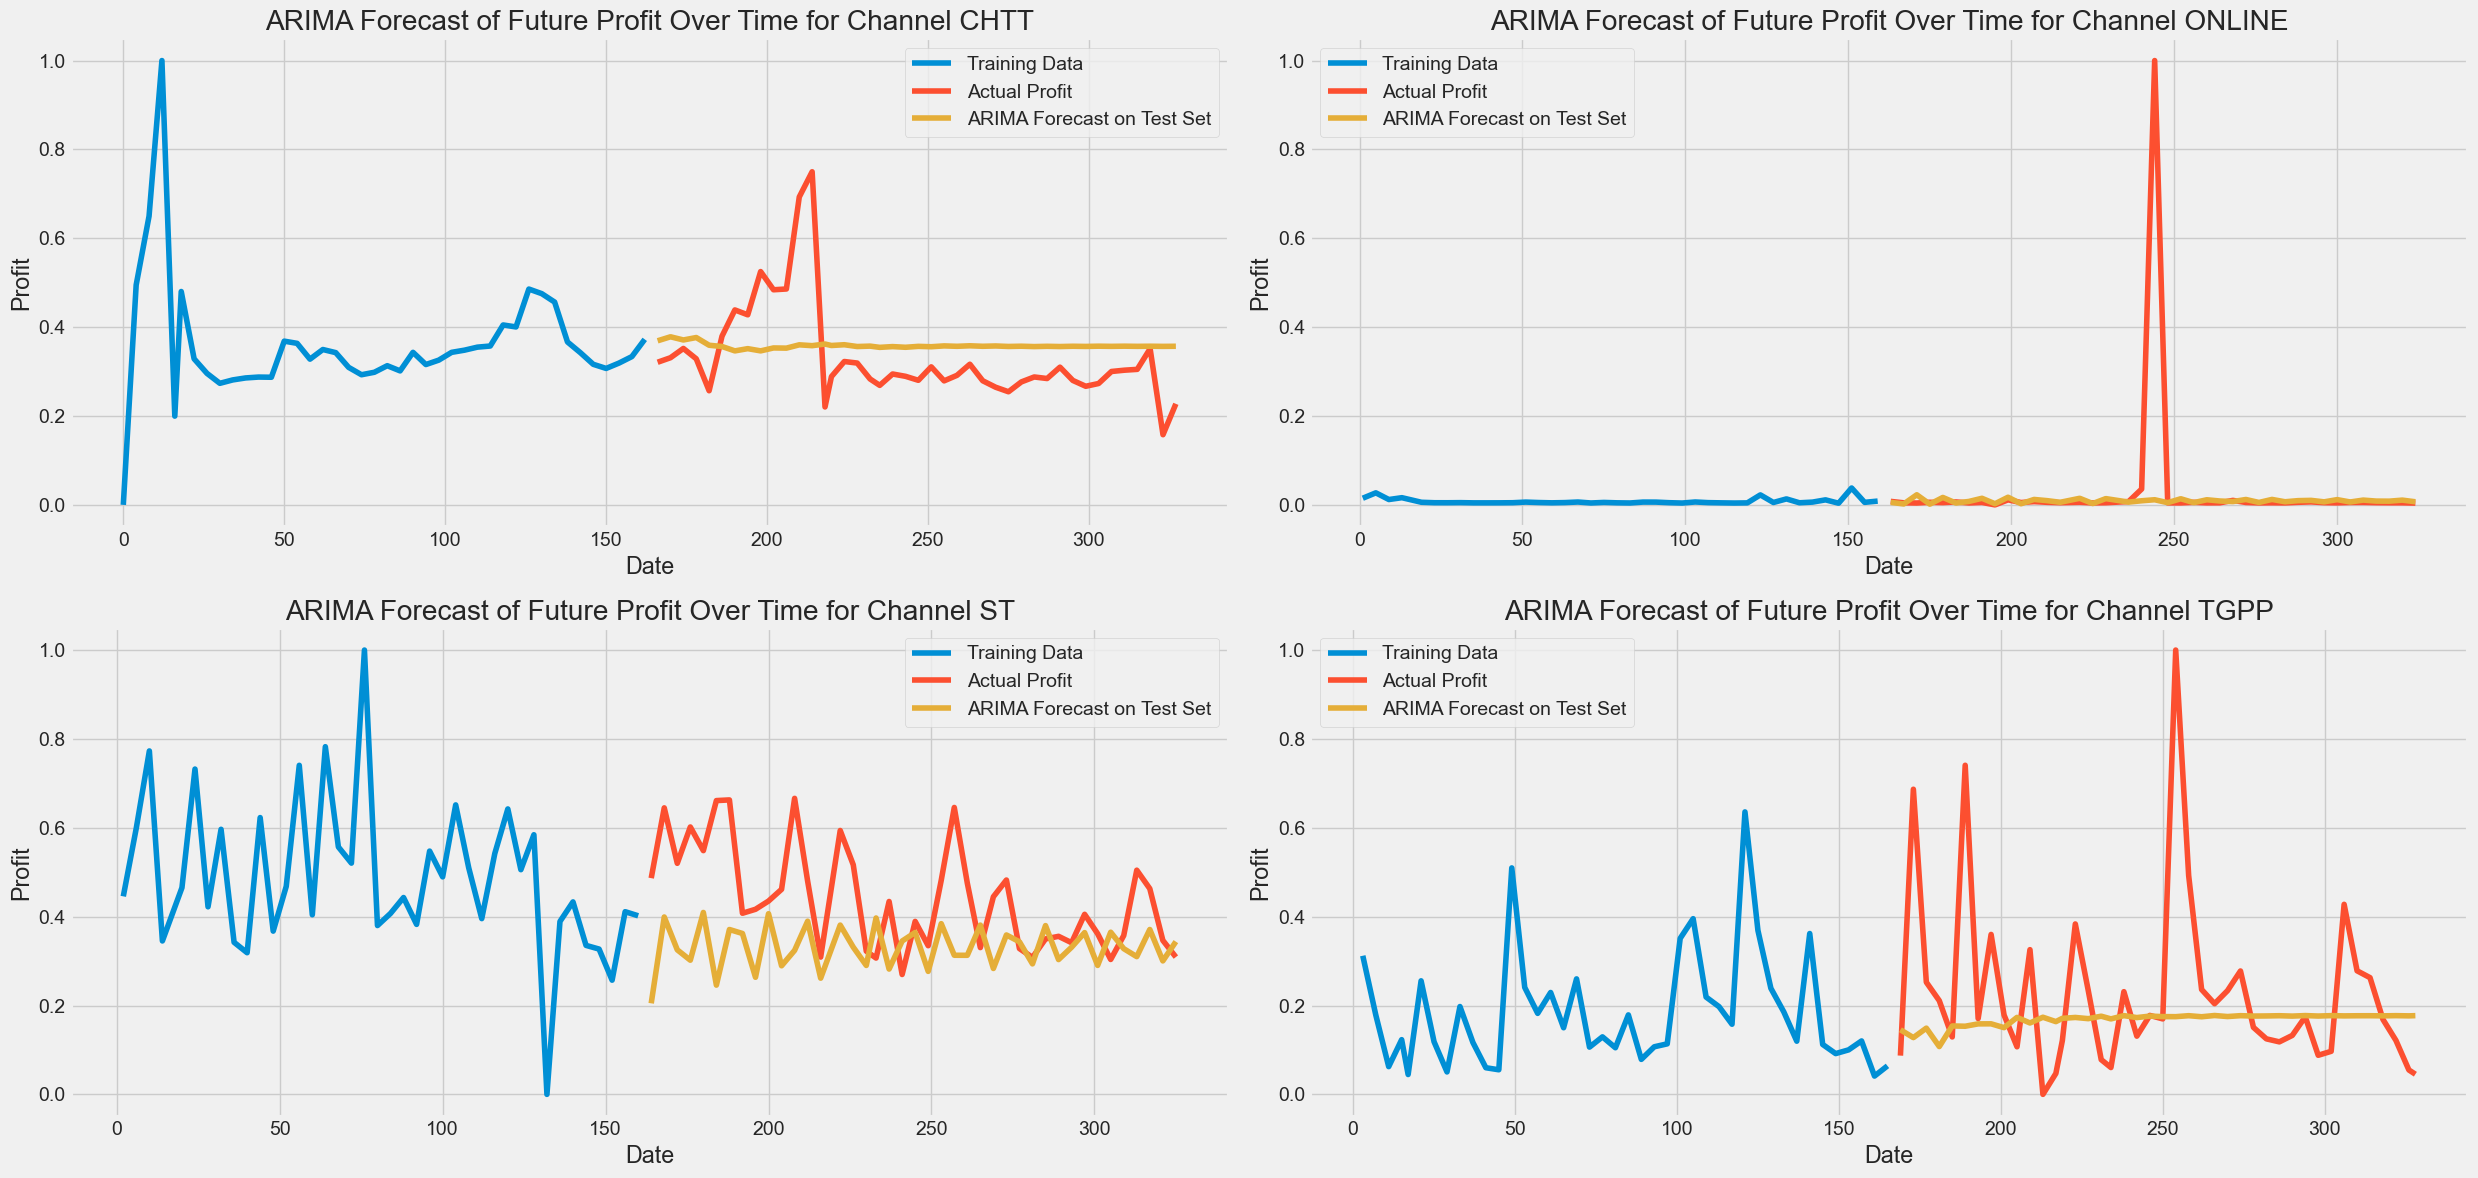

In [21]:
scaler = MinMaxScaler()

fig, axs = plt.subplots(2, 2, figsize=(25, 12))
axs = axs.ravel()

# Loop over each unique channel_id
for i, channel in enumerate(total_profit_over_time['channel_id'].unique()):
    data = total_profit_over_time[total_profit_over_time['channel_id'] == channel]
    data['profit'] = scaler.fit_transform(data[['profit']])

    # Split the data into training and testing sets
    train_size = int(len(data) * 0.5)
    train, test = data[:train_size], data[train_size:]

    # Build and fit the ARIMA model on the training set
    model = ARIMA(train['profit'], order=(5, 1, 2))  # Adjust order as needed
    fit_model = model.fit()

    # Forecast future values on the test set
    forecast_values_test = fit_model.forecast(steps=len(test))

    # Evaluate the model on the test set
    mse_test = mean_squared_error(test['profit'], forecast_values_test)
    print(f'Channel {channel} Test Mean Squared Error: {mse_test}')

    # Visualize the results
    axs[i].plot(train.index, train['profit'], label='Training Data')
    axs[i].plot(test.index, test['profit'], label='Actual Profit')
    axs[i].plot(test.index, forecast_values_test, label='ARIMA Forecast on Test Set')
    axs[i].set_title(f'ARIMA Forecast of Future Profit Over Time for Channel {channel}')
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('Profit')
    axs[i].legend()

plt.tight_layout()
plt.show()

#### **SARIMAX Model**

Channel CHTT Test Mean Squared Error: 0.0225517486656068
Channel ONLINE Test Mean Squared Error: 0.024162654894048934
Channel ST Test Mean Squared Error: 0.07128297678784568
Channel TGPP Test Mean Squared Error: 0.2166829827249834


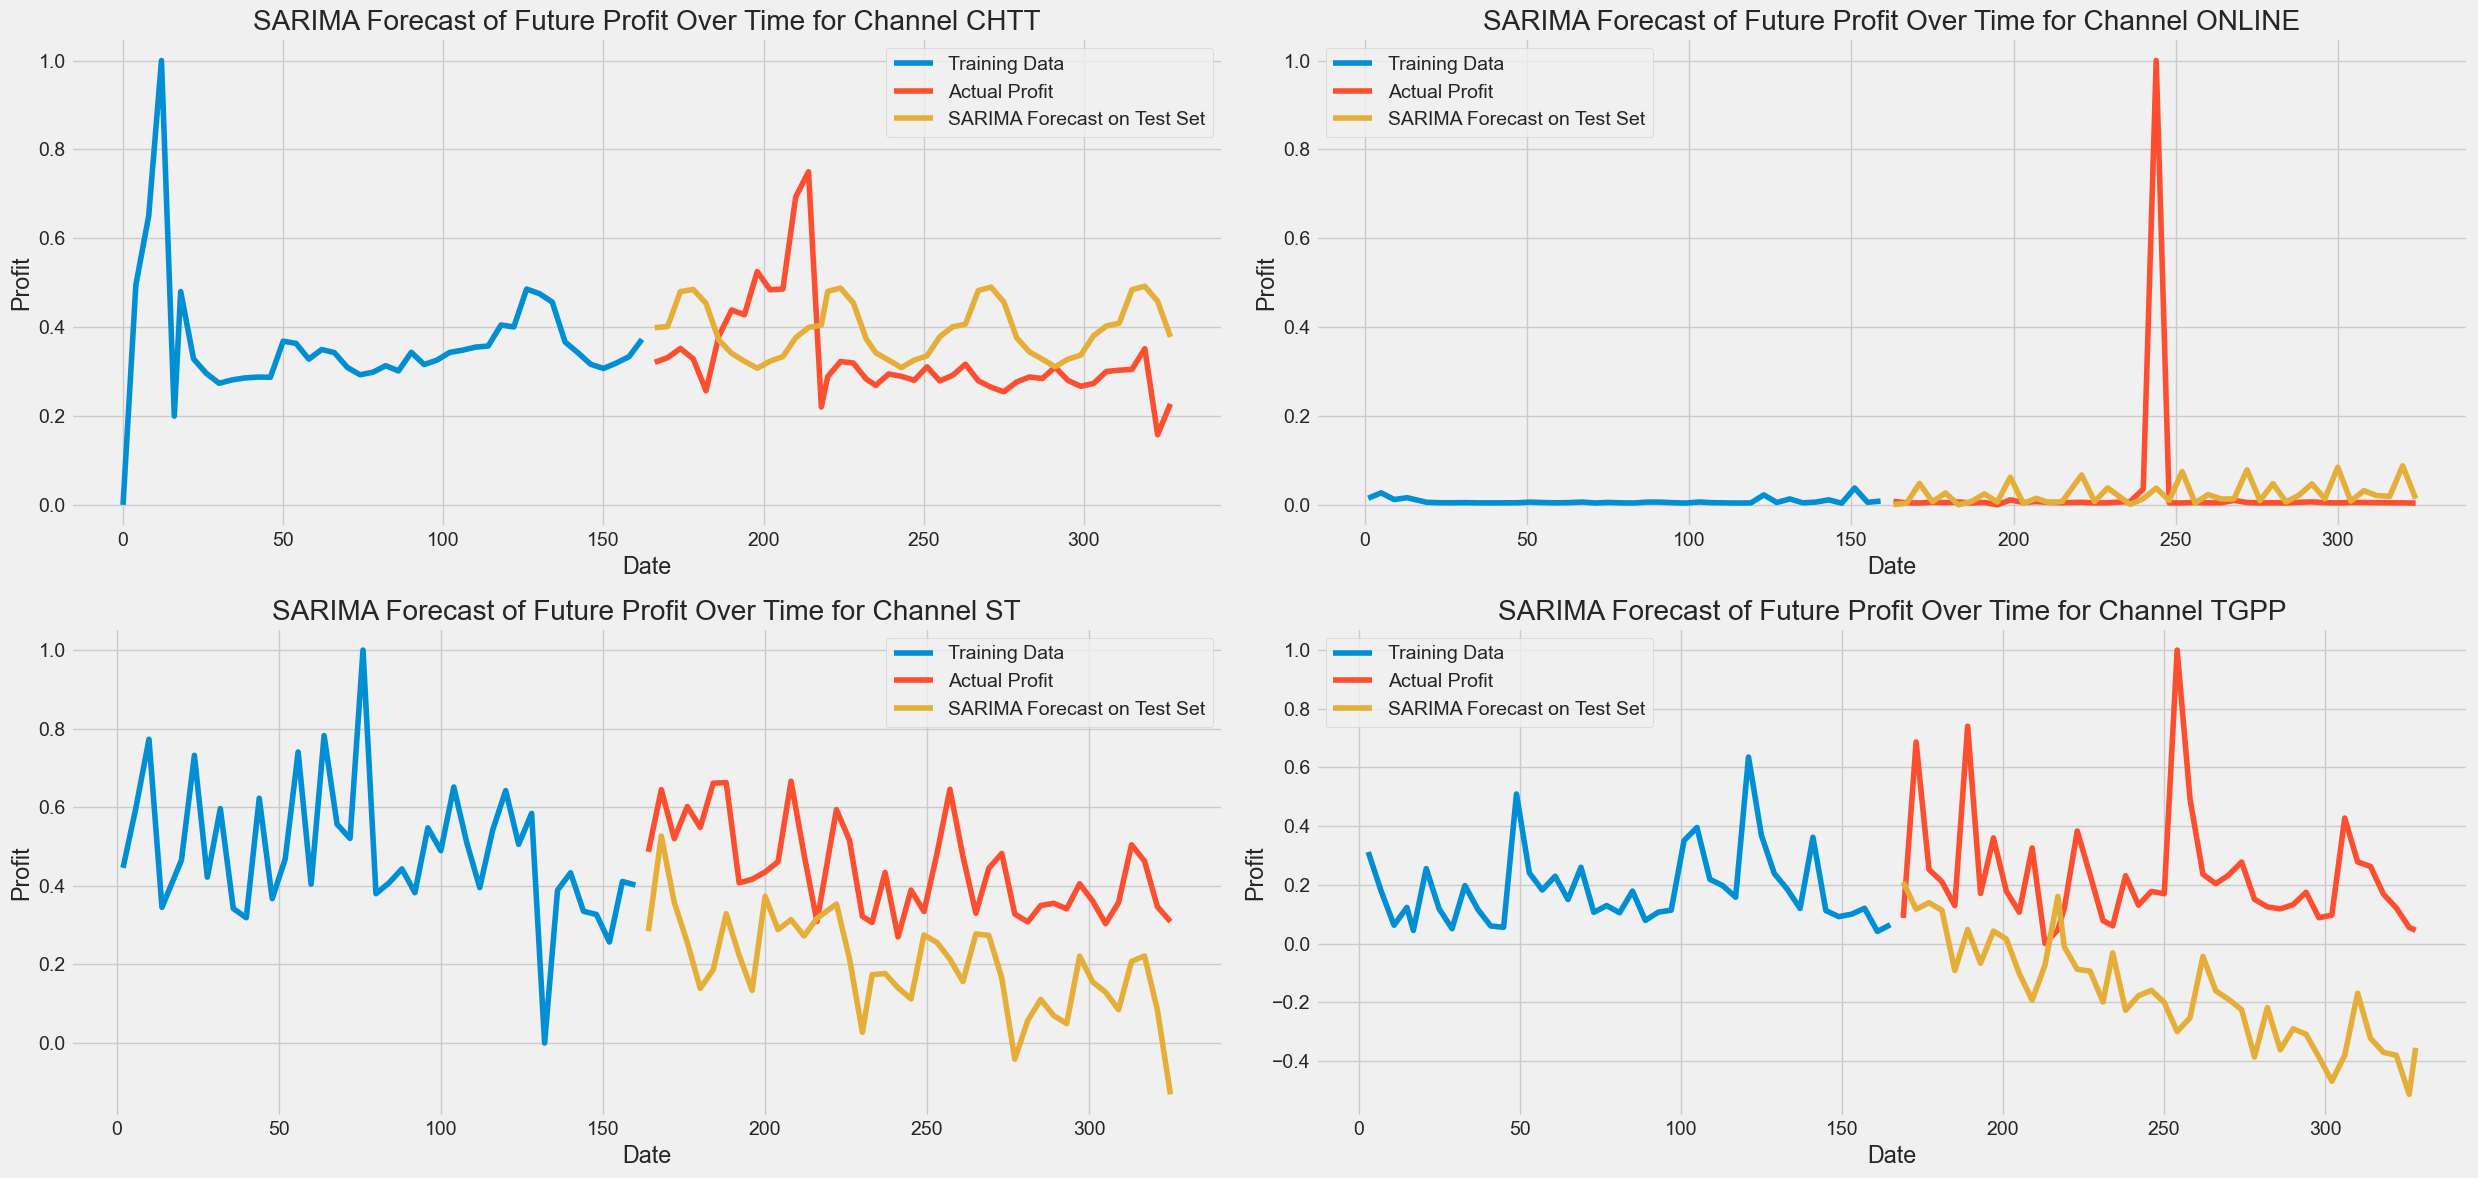

In [22]:

scaler = MinMaxScaler()

fig, axs = plt.subplots(2, 2, figsize=(25, 12))
axs = axs.ravel()

# Loop over each unique channel_id
for i, channel in enumerate(total_profit_over_time['channel_id'].unique()):
    data = total_profit_over_time[total_profit_over_time['channel_id'] == channel]
    data['profit'] = scaler.fit_transform(data[['profit']])

    # Split the data into training and testing sets
    train_size = int(len(data) * 0.5)
    train, test = data[:train_size], data[train_size:]

    # Build and fit the SARIMA model on the training set
    model = SARIMAX(train['profit'], order=(5, 1, 2), seasonal_order=(0, 1, 1, 12))
    fit_model = model.fit()

    # Forecast future values on the test set
    forecast_values_test = fit_model.forecast(steps=len(test))

    # Evaluate the model on the test set
    mse_test = mean_squared_error(test['profit'], forecast_values_test)
    print(f'Channel {channel} Test Mean Squared Error: {mse_test}')

    # Visualize the results
    axs[i].plot(train.index, train['profit'], label='Training Data')
    axs[i].plot(test.index, test['profit'], label='Actual Profit')
    axs[i].plot(test.index, forecast_values_test, label='SARIMA Forecast on Test Set')
    axs[i].set_title(f'SARIMA Forecast of Future Profit Over Time for Channel {channel}')
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('Profit')
    axs[i].legend()

plt.tight_layout()
plt.show()

#### **LSTM Model**

2/2 [==============================] - 0s 3ms/step
Channel CHTT Test Mean Squared Error: 0.0009232154638312678
2/2 [==============================] - 0s 3ms/step
Channel ONLINE Test Mean Squared Error: 0.0029490404613521856
2/2 [==============================] - 0s 3ms/step
Channel ST Test Mean Squared Error: 0.007200597059826026
2/2 [==============================] - 0s 5ms/step
Channel TGPP Test Mean Squared Error: 0.00020248986437548764


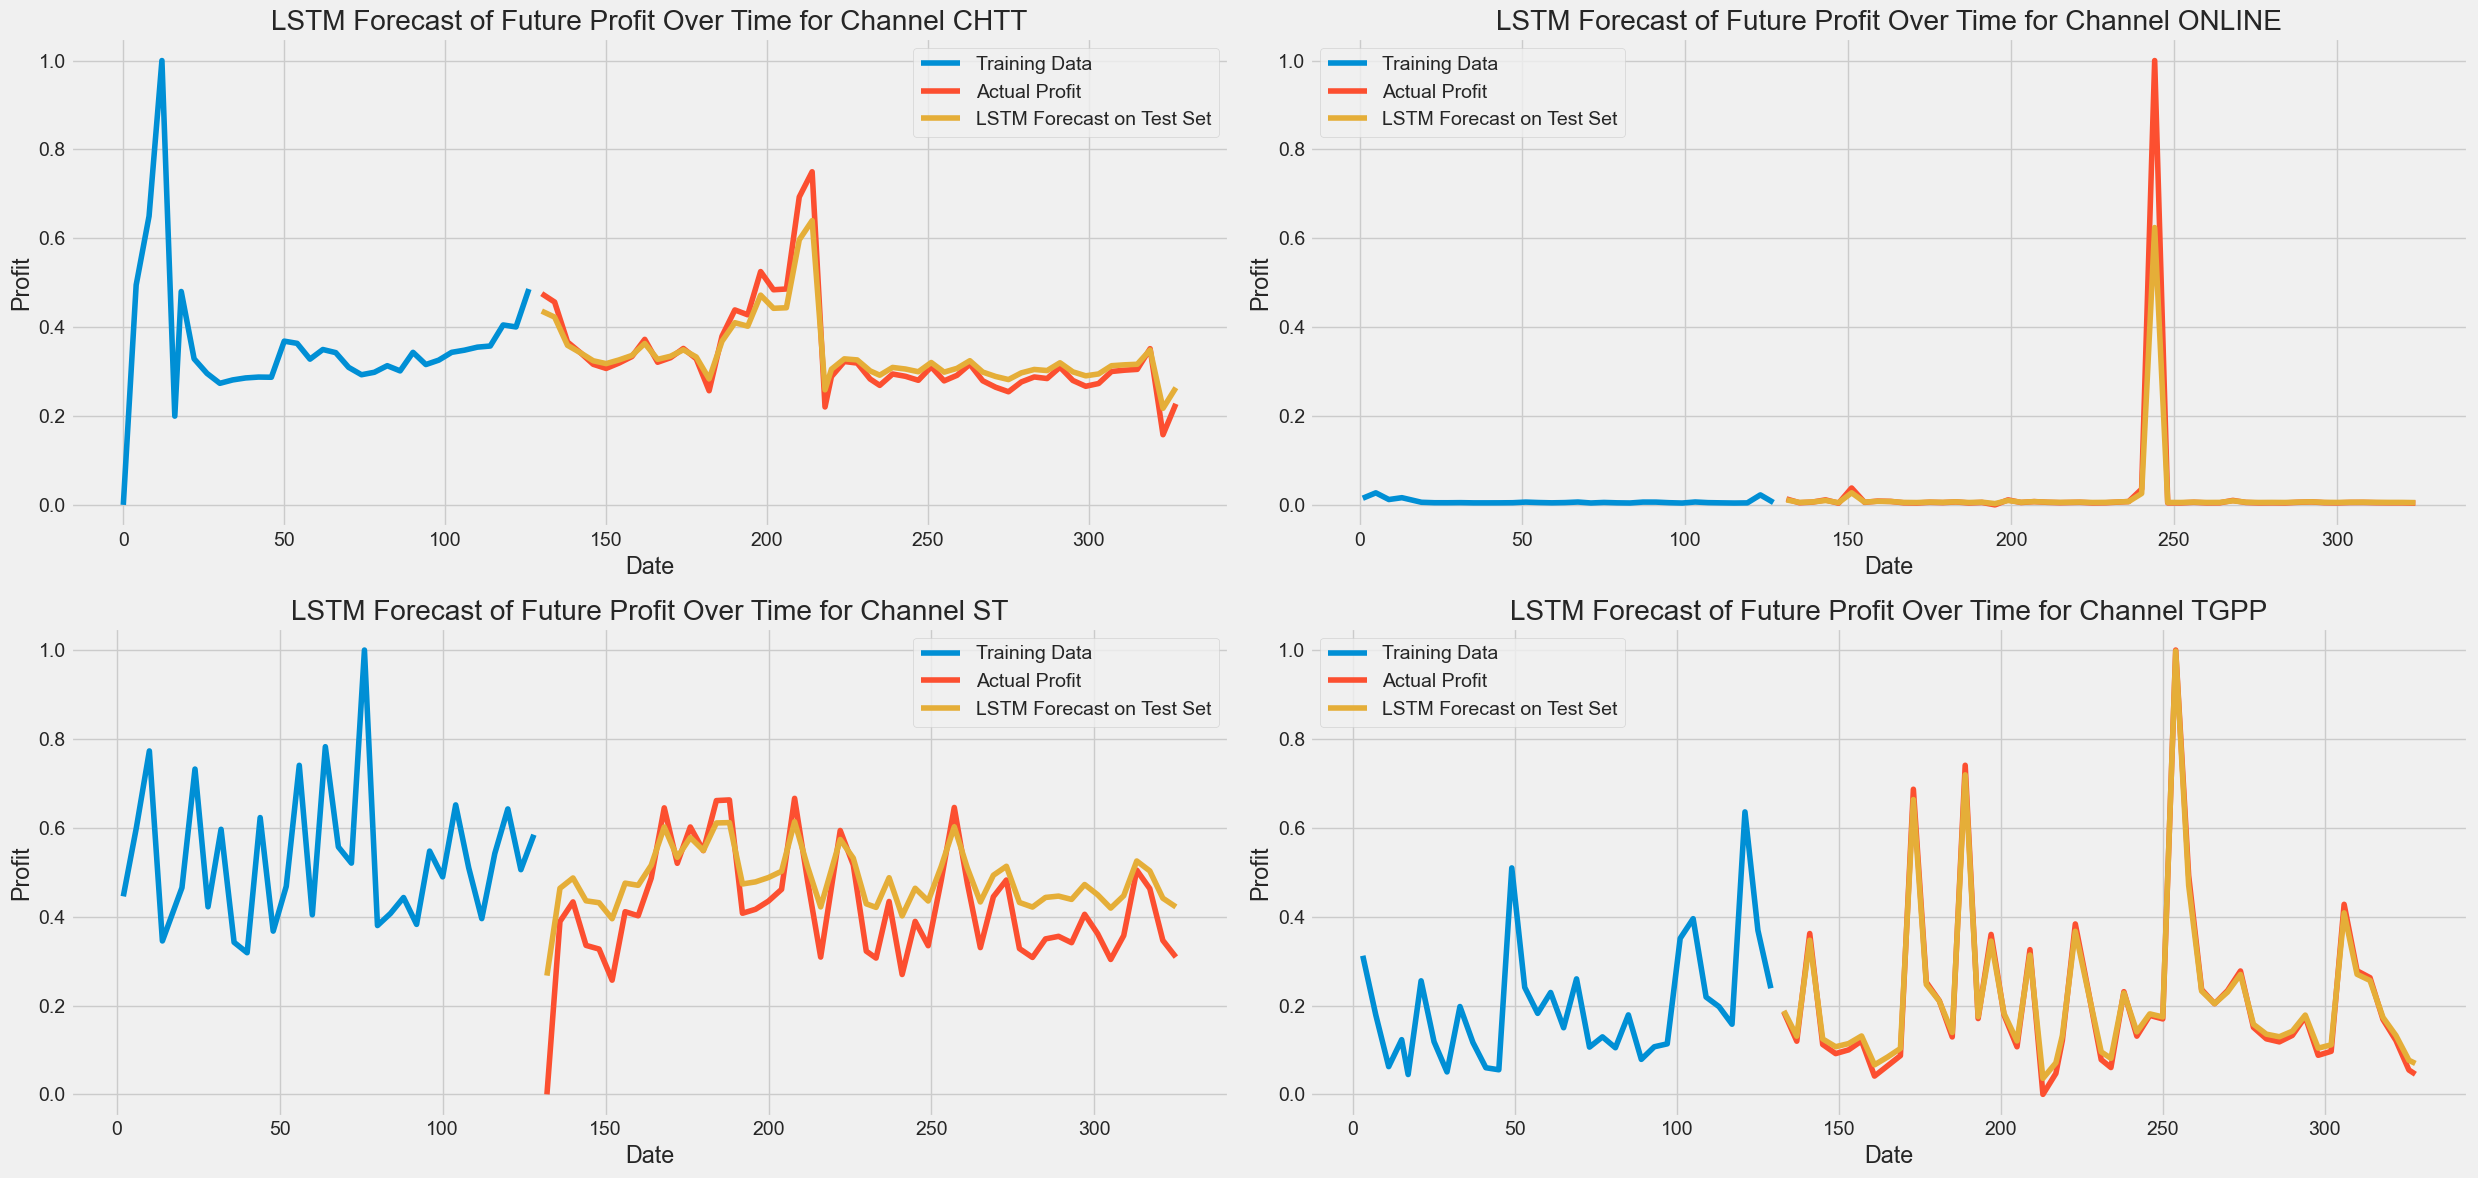

In [33]:
scaler = MinMaxScaler()

fig, axs = plt.subplots(2, 2, figsize=(25, 12))
axs = axs.ravel()

# Loop over each unique channel_id
for i, channel in enumerate(total_profit_over_time['channel_id'].unique()):
    data = total_profit_over_time[total_profit_over_time['channel_id'] == channel]
    data['profit'] = scaler.fit_transform(data[['profit']])

    # Split the data into training and testing sets
    train_size = int(len(data) * 0.4)
    train, test = data[:train_size], data[train_size:]

    # Reshape the data to be 3D, as expected by the LSTM layer
    train_values = np.array(train['profit']).reshape(-1, 1, 1)
    test_values = np.array(test['profit']).reshape(-1, 1, 1)

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(500, activation='relu', input_shape=(1, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    # Fit the model on the training set
    model.fit(train_values, train['profit'], epochs=200, verbose=0)
    model.save(f'../models/lstm_sales_{channel}.keras')

    # Forecast future values on the test set
    forecast_values_test = model.predict(test_values)

    # Evaluate the model on the test set
    mse_test = mean_squared_error(test['profit'], forecast_values_test)
    print(f'Channel {channel} Test Mean Squared Error: {mse_test}')

    # Visualize the results
    axs[i].plot(train.index, train['profit'], label='Training Data')
    axs[i].plot(test.index, test['profit'], label='Actual Profit')
    axs[i].plot(test.index, forecast_values_test, label='LSTM Forecast on Test Set')
    axs[i].set_title(f'LSTM Forecast of Future Profit Over Time for Channel {channel}')
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('Profit')
    axs[i].legend()

plt.tight_layout()
plt.show()

In [24]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

one_hot_encoder = OneHotEncoder()
label_encoder = LabelEncoder()

# Apply One Hot Encoding
one_hot_cols = ['channel_id', 'distribution_channel']
for col in one_hot_cols:
    sales_data = pd.concat([sales_data, pd.get_dummies(sales_data[col], prefix=col)], axis=1)
    sales_data.drop(col, axis=1, inplace=True)

# Apply Label Encoding
label_cols = ['distribution_channel_code', 'customer_id', 'product_id']
for col in label_cols:
    sales_data[col] = label_encoder.fit_transform(sales_data[col])

In [25]:
cols_to_convert = sales_data.filter(regex='^(channel_id|distribution_channel)').columns

for col in cols_to_convert:
    sales_data[col] = sales_data[col].astype('int64')

In [26]:
sales_data.columns

Index(['Unnamed: 0', 'site', 'branch_id', 'distribution_channel_code',
       'sold_quantity', 'cost_price', 'net_price', 'customer_id', 'product_id',
       'total_sales', 'date', 'total_cost', 'profit', 'channel_id_CHTT',
       'channel_id_ONLINE', 'channel_id_ST', 'channel_id_TGPP',
       'distribution_channel_-', 'distribution_channel_Bán lẻ',
       'distribution_channel_Bán sỉ', 'distribution_channel_Hợp đồng',
       'distribution_channel_Online', 'distribution_channel_Phát sinh',
       'distribution_channel_Siêu thị'],
      dtype='object')

In [27]:
sales_data.dtypes

Unnamed: 0                                 int64
site                                       int64
branch_id                                  int64
distribution_channel_code                  int64
sold_quantity                              int64
cost_price                                 int64
net_price                                  int64
customer_id                                int32
product_id                                 int32
total_sales                                int64
date                              datetime64[ns]
total_cost                                 int64
profit                                     int64
channel_id_CHTT                            int64
channel_id_ONLINE                          int64
channel_id_ST                              int64
channel_id_TGPP                            int64
distribution_channel_-                     int64
distribution_channel_Bán lẻ                int64
distribution_channel_Bán sỉ                int64
distribution_channel

In [28]:
y = sales_data['profit']
X = sales_data.drop(['profit', 'date'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# create a list of models to evaluate
models = []
models.append(('LR', LinearRegression()))
models.append(('XGB', XGBRegressor()))

In [29]:
results = []
names = []
for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    results.append(cv_results)
    names.append(name)
    print(f"{name}: {cv_results.mean()} ({cv_results.std()})")

LR: 0.866390907608394 (0.2363944010378511)
XGB: 0.4123930946688234 (0.18236307862959183)


### **HyperParameter Tunning**

In [30]:
param_grid = {
    'learning_rate': [0.05, 0.007, 0.1, 0.15],
    'n_estimators': [500, 750, 100],
}

grid_search = GridSearchCV( 
    XGBRegressor(),
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_squared_error'
)

grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

KeyboardInterrupt: 

In [ ]:
print("Best Model's Parameters: ", grid_search.best_params_)

# evaluate the best model on the test set
y_pred = grid_search.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"Best Model's RMSE on Test Set: {rmse}")

Best Model's Parameters:  {'learning_rate': 0.15, 'n_estimators': 750}
Best Model's RMSE on Test Set: 4998435.33248536


In [ ]:
r2_test = r2_score(y_test,y_pred)
print("R Squared Value : ",r2_test)

R Squared Value :  0.7952122477214649


In [ ]:
model = XGBRegressor(n_estimators = 750,learning_rate = 0.15)
model.fit(X_train,y_train)
# trainning data prediction
y_pred = model.predict(X_test)

# R squared value
r2_test = r2_score(y_test,y_pred)
print("R Squared Value : ",r2_test)

R Squared Value :  0.7952122477214649


### **Inventory data area**

Inventory data includes multiple files representing information on inventory management across plants (stocks), the data is collected between 2022 and 2023 at the end of every two months. The file follow the format

`<date>-<month>-<year>_Ton Kho <start_plant_id>-<end_plant_id>.xlsx`

Where

`<date>-<month>-<year>` represents the date that inventory data is collected

`<start_plant_id>-<end_plant_id>` represents the range of plants (stocks) id in the files.

For instance, the file “31-10-2022_Ton Kho 1161-1170.xlsx” represents the inventory management data collected at the end of October in the stocks having IDs from 1161 to 1170

Each file includes the following data fields:

- plant: the id of plant/stock
- calendar_year: year
- calendar_yeer_week: week in year
- sloc: site location
- quantity: represents the overall inventory quantity of products
- total_amount: a total of monetary values
- product_id: represents the product ID

In [ ]:
if os.path.isfile('../clean_data/inventories.csv'):
    inventory_df = pd.read_csv('../clean_data/inventories.csv')
else:
    inventory_files = glob.glob("..data/Inventory_mentor/*-*-*_Ton Kho *.xlsx")
    inventory_df = pd.DataFrame()

    for file in inventory_files:
        df = pd.read_excel(file, index_col=None)
        inventory_df = pd.concat([inventory_df, df], ignore_index=True)
        
    inventory_df = inventory_df.drop(columns=['Unnamed: 0', 'index'])

In [ ]:
inventory_df

plant        date  sloc  quantity  total_amount  \
0         1101  2022-02-28  3000        17       17000.0   
1         1101  2022-02-28  3000        48       34000.0   
2         1101  2022-02-28  3000        87           0.0   
3         1101  2022-02-28  3000        80      -34000.0   
4         1101  2022-02-28  3000       128       68000.0   
...        ...         ...   ...       ...           ...   
4008718   2001  2022-12-31  3000         1           0.0   
4008719   2001  2022-12-31  3000         1           0.0   
4008720   2001  2022-12-31  3000         2           0.0   
4008721   2001  2022-12-31  3000         2           0.0   
4008722   2001  2022-12-31  3000         2           0.0   

                                    product_id  
0        1259098aaa8e447181f13903f84e5db1OOO35  
1        39b38616e4d649ab9c3b7d04e82e079fOOO36  
2        8db14e88898e40a392f80ed69c30e206OOO37  
3        7c15de90afd343338f93c8f65a0d8380OOO38  
4        6c04a173aec34690b242ed4e09367e96OOO39  
...                                        ...  
4008718  52de17c640cc4085a863cf9d18ddeb6fNAU35  
4008719  267a3bb60d1d4fe8bfeb53107482914fNAU36  
4008720  8aab639678b84044a99fa92cab5203aaNAU37  
4008721  f9bfb859e6c846a086ed6985ba6b7c74NAU38  
4008722  b1ac885eaec74de0b52cee589bde4f98NAU39  

[4008723 rows x 6 columns]

In [ ]:
inventory_df[inventory_df['quantity'] <= 0]

plant  calendar_year  calendar_yeer_week  sloc  quantity  \
439402    1264           2023            20230228  3000         0   
1310565   1264           2022            20220930  3000         0   
2227531   1264           2023            20230131  3000         0   

         total_amount                             product_id  
439402            0.0  4fdbf080b6ad48a28ae2fc67d950ffb2XAM33  
1310565           0.0  4fdbf080b6ad48a28ae2fc67d950ffb2XAM33  
2227531           0.0  4fdbf080b6ad48a28ae2fc67d950ffb2XAM33

In [ ]:
unique_values = inventory_df['calendar_year_week'].unique()

unique_values

KeyError: 'calendar_year_week'

In [ ]:
inventory_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4008723 entries, 0 to 4008722
Data columns (total 7 columns):
 #   Column              Dtype  
---  ------              -----  
 0   plant               int64  
 1   calendar_year       int64  
 2   calendar_yeer_week  int64  
 3   sloc                object 
 4   quantity            int64  
 5   total_amount        float64
 6   product_id          object 
dtypes: float64(1), int64(4), object(2)
memory usage: 214.1+ MB


In [ ]:
inventory_df.describe()

plant      quantity  total_amount
count  4.008723e+06  4.008723e+06  4.008723e+06
mean   1.313195e+03  2.293053e+00  5.070792e+04
std    2.040280e+02  1.180283e+01  7.159304e+06
min    1.100000e+03  0.000000e+00 -9.578056e+08
25%    1.148000e+03  1.000000e+00  0.000000e+00
50%    1.241000e+03  1.000000e+00  0.000000e+00
75%    1.507000e+03  2.000000e+00  0.000000e+00
max    2.001000e+03  7.403000e+03  2.466819e+09

In [ ]:
num_missing = inventory_df.isnull().sum().sum()

print(f'Number of missing values: {num_missing}')

Number of missing values: 0


In [ ]:
inventory_df['calendar_yeer_week'] = pd.to_datetime(inventory_df['calendar_yeer_week'])

KeyError: 'calendar_yeer_week'

In [ ]:
inventory_df['calendar_yeer_week']

0         1970-01-01 00:00:00.020220228
1         1970-01-01 00:00:00.020220228
2         1970-01-01 00:00:00.020220228
3         1970-01-01 00:00:00.020220228
4         1970-01-01 00:00:00.020220228
                       ...             
4008718   1970-01-01 00:00:00.020221231
4008719   1970-01-01 00:00:00.020221231
4008720   1970-01-01 00:00:00.020221231
4008721   1970-01-01 00:00:00.020221231
4008722   1970-01-01 00:00:00.020221231
Name: calendar_yeer_week, Length: 4008723, dtype: datetime64[ns]

#### **Some EDA about `Inventory data area`**

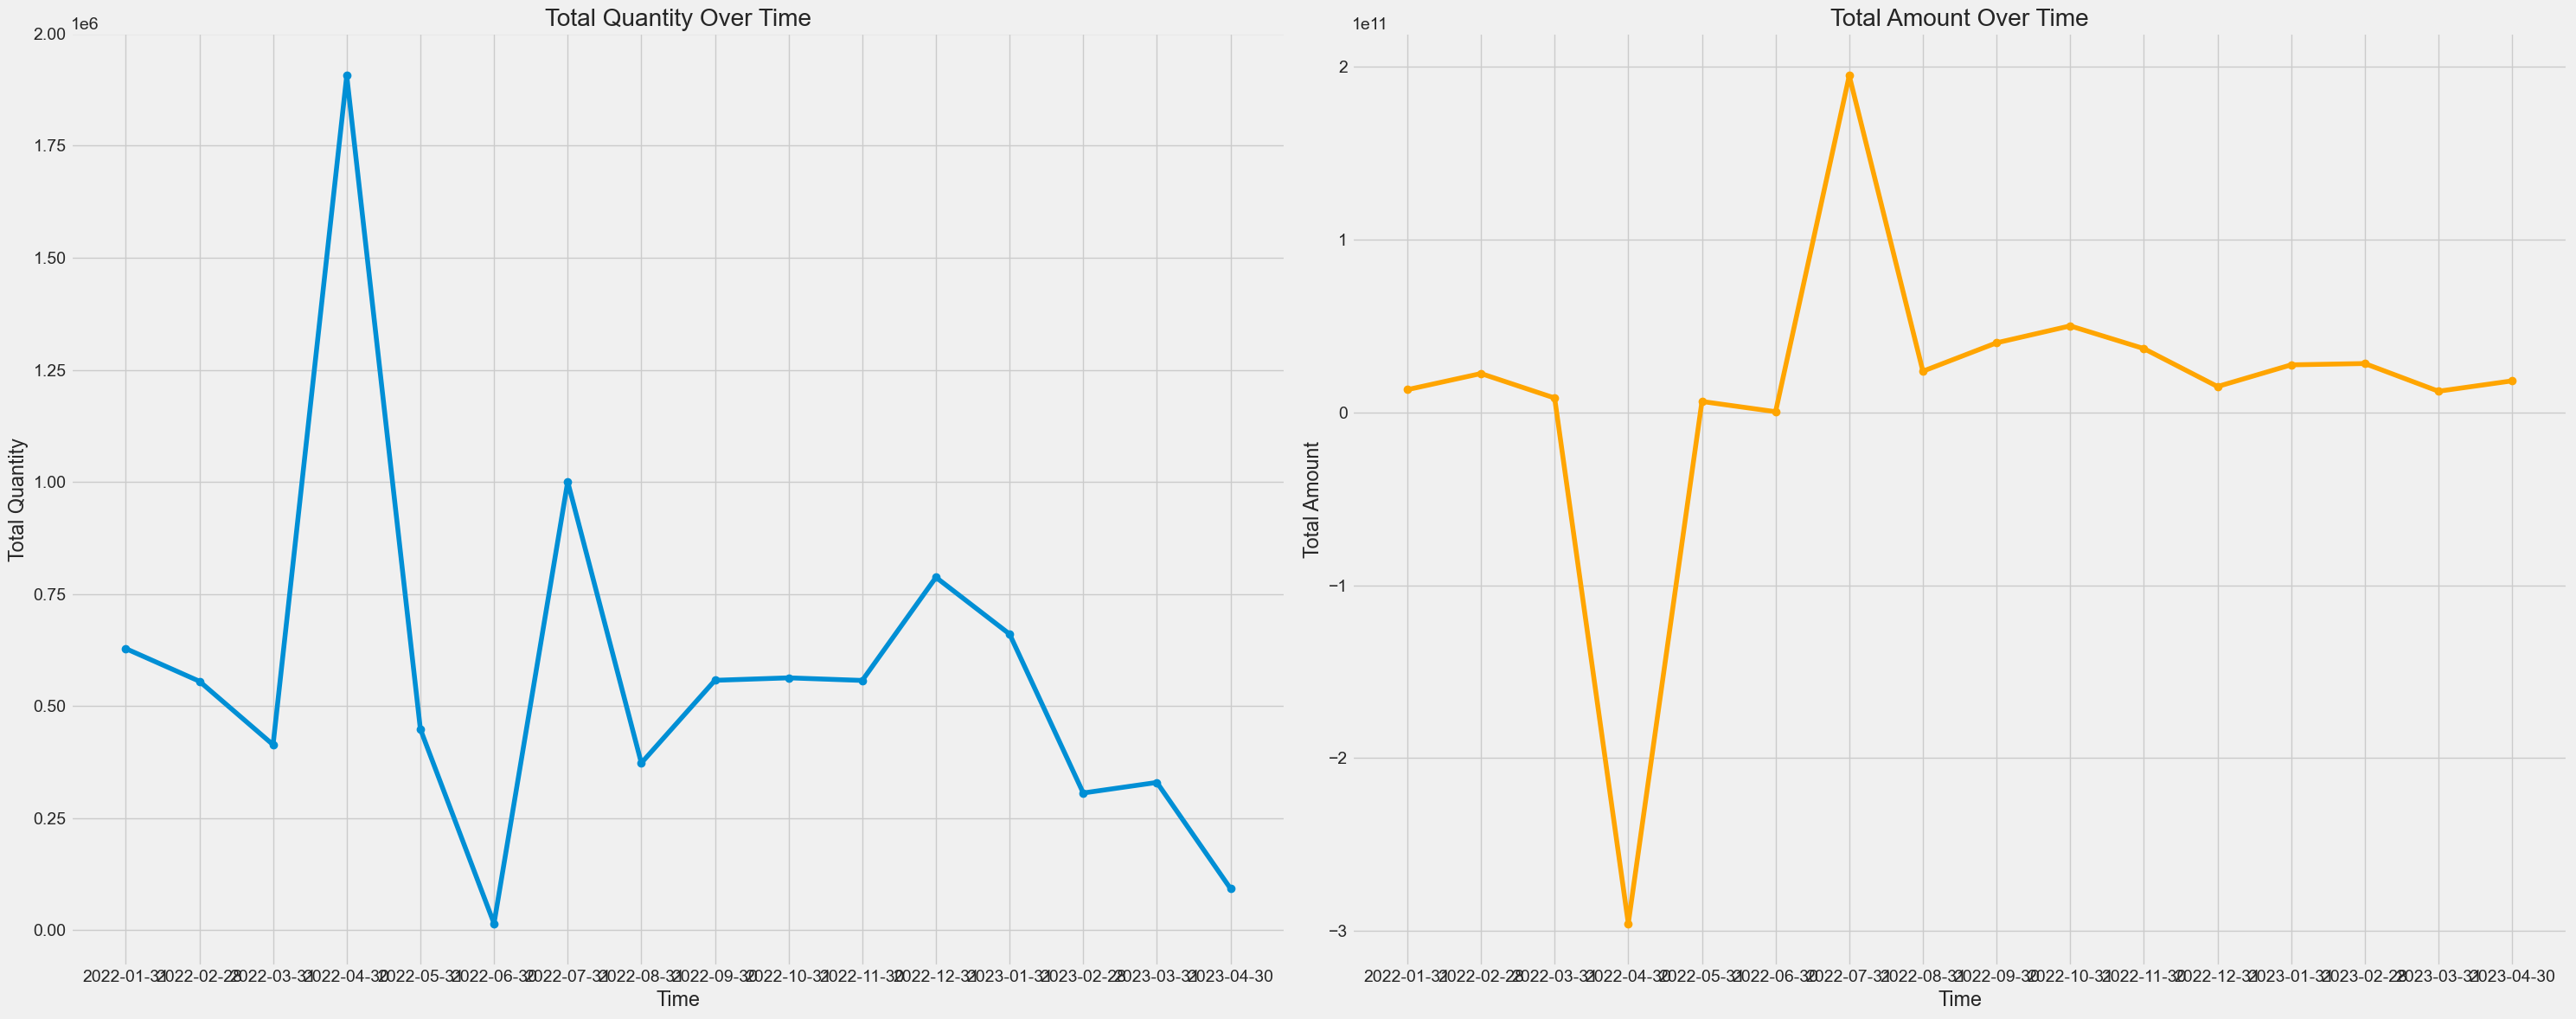

In [ ]:
total_quantity_over_year = inventory_df.groupby('date')['quantity'].sum().reset_index()
total_amount_over_year = inventory_df.groupby('date')['total_amount'].sum().reset_index()

# Plotting
plt.figure(figsize=(30, 12))

# Total Quantity Over the Year
plt.subplot(1, 2, 1)
plt.plot(total_quantity_over_year['date'], total_quantity_over_year['quantity'], marker='o')
plt.title('Total Quantity Over Time')
plt.xlabel('Time')
plt.ylabel('Total Quantity')

# Total Amount Over the Year
plt.subplot(1, 2, 2)
plt.plot(total_amount_over_year['date'], total_amount_over_year['total_amount'], marker='o', color='orange')
plt.title('Total Amount Over Time')
plt.xlabel('Time')
plt.ylabel('Total Amount')

plt.tight_layout()
plt.show()

### **Productmaster.xlsx**

- color: Product colors by gender category
- color group: similar color groups
- listing_price: detail price of each product
- price_group: different price groups can influence consumer decisions
- gender: The product users are classified by gender and age
- product_group: Group of products with similar characteristics in terms of design and structure
- detail_product_group: Group of product types with similar characteristics in terms of design and structure.
- shoe_product: Group of shoe product details with similar characteristics in terms of material
- size_group: main frame sizes by gender group or special and exceptional frames
- size: Size of each individual product detail
- age_group: Age groups with different preferences and comsumer behaviors
- activity_group: A collection of activities with similar usage purposes
- image_copyright: Detailed copyright character name
- lifestyle_group: the fashion styles that comsumers aspire to when choosing products
- launch_season: the time period during
- mold_code: information about the product’s heel code
- heel_height: group of products with a common heel height
- option: a collection of product codes with similar details
- cost_price: includes all the expenses associated with producing or acquiring a product
- product_id: represents the product ID
- product_style_color: represents the style color of a product
- product_style: represents the style color of a product
- brand_name: name of the branch
- vendor_name: name of the vendor

In [ ]:
product_detail_df = pd.read_csv('../data/product_detail.csv', index_col=None)

In [ ]:
product_detail_df

color color_group  listing_price price_group gender product_group  \
0       DEN         TỐI       255273.0     200<300    MEN           SAN   
1       DEN         TỐI       255273.0     200<300    MEN           SAN   
2       DEN         TỐI       255273.0     200<300    MEN           SAN   
3       DEN         TỐI       255273.0     200<300    MEN           SAN   
4       DEN         TỐI       255273.0     200<300    MEN           SAN   
...     ...         ...            ...         ...    ...           ...   
94862   CAM         TỐI            NaN         NaN    MEN           PKI   
94863   CAM         TỐI            NaN         NaN    MEN           PKI   
94864   CAM         TỐI            NaN         NaN    MEN           PKI   
94865   CAM         TỐI            NaN         NaN    MEN           PKI   
94866   CAM         TỐI            NaN         NaN    MEN           PKI   

      detail_product_group shoe_product size_group  size  ...  \
0                    SANTD          STT   Ngoại lệ  38.0  ...   
1                    SANTD          STT   Ngoại lệ  39.0  ...   
2                    SANTD          STT   Ngoại lệ  40.0  ...   
3                    SANTD          STT   Ngoại lệ  41.0  ...   
4                    SANTD          STT   Ngoại lệ  42.0  ...   
...                    ...          ...        ...   ...  ...   
94862                PKIEN          PKG   Đặc biệt  35.0  ...   
94863                PKIEN          PKG   Đặc biệt  37.0  ...   
94864                PKIEN          PKG   Đặc biệt  39.0  ...   
94865                PKIEN          PKG   Đặc biệt  41.0  ...   
94866                PKIEN          PKG   Đặc biệt  43.0  ...   

                   name_description mch_description code_lock   option  \
0      Khóa mã theo TB022 P.ĐH&ĐPTT  NHÓM HÀNG CHẬM         x  P03-C05   
1      Khóa mã theo TB022 P.ĐH&ĐPTT  NHÓM HÀNG CHẬM         x  P03-C05   
2      Khóa mã theo TB022 P.ĐH&ĐPTT  NHÓM HÀNG CHẬM         x  P03-C05   
3      Khóa mã theo TB022 P.ĐH&ĐPTT  NHÓM HÀNG CHẬM         x  P03-C05   
4      Khóa mã theo TB022 P.ĐH&ĐPTT  NHÓM HÀNG CHẬM         x  P03-C05   
...                             ...             ...       ...      ...   
94862    các loại phụ kiện, Cam, 35   NHÓM PHỤ KIỆN       NaN        0   
94863    các loại phụ kiện, Cam, 37   NHÓM PHỤ KIỆN       NaN        0   
94864    các loại phụ kiện, Cam, 39   NHÓM PHỤ KIỆN       NaN        0   
94865    các loại phụ kiện, Cam, 41   NHÓM PHỤ KIỆN       NaN        0   
94866    các loại phụ kiện, Cam, 43   NHÓM PHỤ KIỆN       NaN        0   

      cost_price                             product_id  \
0       176800.0  80e1107e5bf74598baffea3a7b6073c5DEN38   
1       176800.0  c8223e6133a64491a006dc0f95c2bfd9DEN39   
2       176800.0  bec30e131ee04e49a4c87bc56f135b13DEN40   
3       176800.0  3f4e265b0ac740e9b9edfd23e0ba1ca5DEN41   
4       176800.0  53e6284597944ec787e002b631391210DEN42   
...          ...                                    ...   
94862        NaN  00cb29b5c14f4b22a90b4fd804e2d498CAM35   
94863        NaN  0980b5ae05be404e8d3cd627f77371c2CAM37   
94864        NaN  ee6cd28b3ad547b1ba97f389da5b6220CAM39   
94865        NaN  c4ec68c1036348cd8feb1a58c6adeddaCAM41   
94866        NaN  ac83f20a7291485f9f73299e2a0a2487CAM43   

                        product_syle_color                      product_syle  \
0      80e1107e5bf74598baffea3a7b6073c5DEN  80e1107e5bf74598baffea3a7b6073c5   
1      c8223e6133a64491a006dc0f95c2bfd9DEN  c8223e6133a64491a006dc0f95c2bfd9   
2      bec30e131ee04e49a4c87bc56f135b13DEN  bec30e131ee04e49a4c87bc56f135b13   
3      3f4e265b0ac740e9b9edfd23e0ba1ca5DEN  3f4e265b0ac740e9b9edfd23e0ba1ca5   
4      53e6284597944ec787e002b631391210DEN  53e6284597944ec787e002b631391210   
...                                    ...                               ...   
94862  00cb29b5c14f4b22a90b4fd804e2d498CAM  00cb29b5c14f4b22a90b4fd804e2d498   
94863  0980b5ae05be404e8d3cd627f77371c2CAM  0980b5ae05be404e8d3cd627f77371c2   
94864 

In [ ]:
product_detail_df.to_csv('../data/product_detail.csv', index=False)

In [ ]:
product_detail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94867 entries, 0 to 94866
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   color                 94822 non-null  object 
 1   color_group           94867 non-null  object 
 2   listing_price         94840 non-null  float64
 3   price_group           94840 non-null  object 
 4   gender                94867 non-null  object 
 5   product_group         94867 non-null  object 
 6   detail_product_group  94867 non-null  object 
 7   shoe_product          94867 non-null  object 
 8   size_group            94867 non-null  object 
 9   size                  94722 non-null  float64
 10  age_group             94867 non-null  object 
 11  activity_group        94867 non-null  object 
 12  collection            94862 non-null  object 
 13  image_copyright       94867 non-null  object 
 14  product_line          94867 non-null  object 
 15  lifestyle_group    

### Feature Engineering

In [ ]:
product_detail_df['gender'] = product_detail_df['gender'].replace({'BOY': 'MEN', 'GIR': 'WOM'})

In [ ]:
product_detail_df['profit'] = product_detail_df['listing_price'] - product_detail_df['cost_price']
product_detail_df['profit']

0        78473.0
1        78473.0
2        78473.0
3        78473.0
4        78473.0
          ...   
94862        NaN
94863        NaN
94864        NaN
94865        NaN
94866        NaN
Name: profit, Length: 94867, dtype: float64

In [ ]:
num_nan = product_detail_df.isna().sum().sum()

print(f'Number of NaN values: {num_nan}')

num_missing = product_detail_df.isnull().sum().sum()

print(f'Number of missing values: {num_missing}')

Number of NaN values: 141902
Number of missing values: 141902


In [ ]:
missing_values = product_detail_df.isnull().sum()

# Print the columns with missing values and their counts
print(missing_values[missing_values > 0])

color                 45
listing_price         27
price_group           27
size                 145
collection             5
lifestyle_group      179
mold_code          63658
heel_height        10257
code_lock          61666
cost_price           235
vendor_name         5423
profit               235
dtype: int64


For columns `cost_price` and `listing_price` replace missing values with mean value

In [ ]:
# Calculate the mean values
mean_cost_price = product_detail_df['cost_price'].mean()
mean_listing_price = product_detail_df['listing_price'].mean()

# Fill missing values in 'cost_price' and 'listing_price' with their respective mean values
product_detail_df['cost_price'] = product_detail_df['cost_price'].fillna(mean_cost_price)
product_detail_df['listing_price'] = product_detail_df['listing_price'].fillna(mean_listing_price)

In [ ]:
product_detail_df = product_detail_df.dropna()

In [ ]:
num_missing = product_detail_df.isnull().sum().sum()

print(f'After Handling, Number of missing values: {num_missing}')

After Handling, Number of missing values: 0


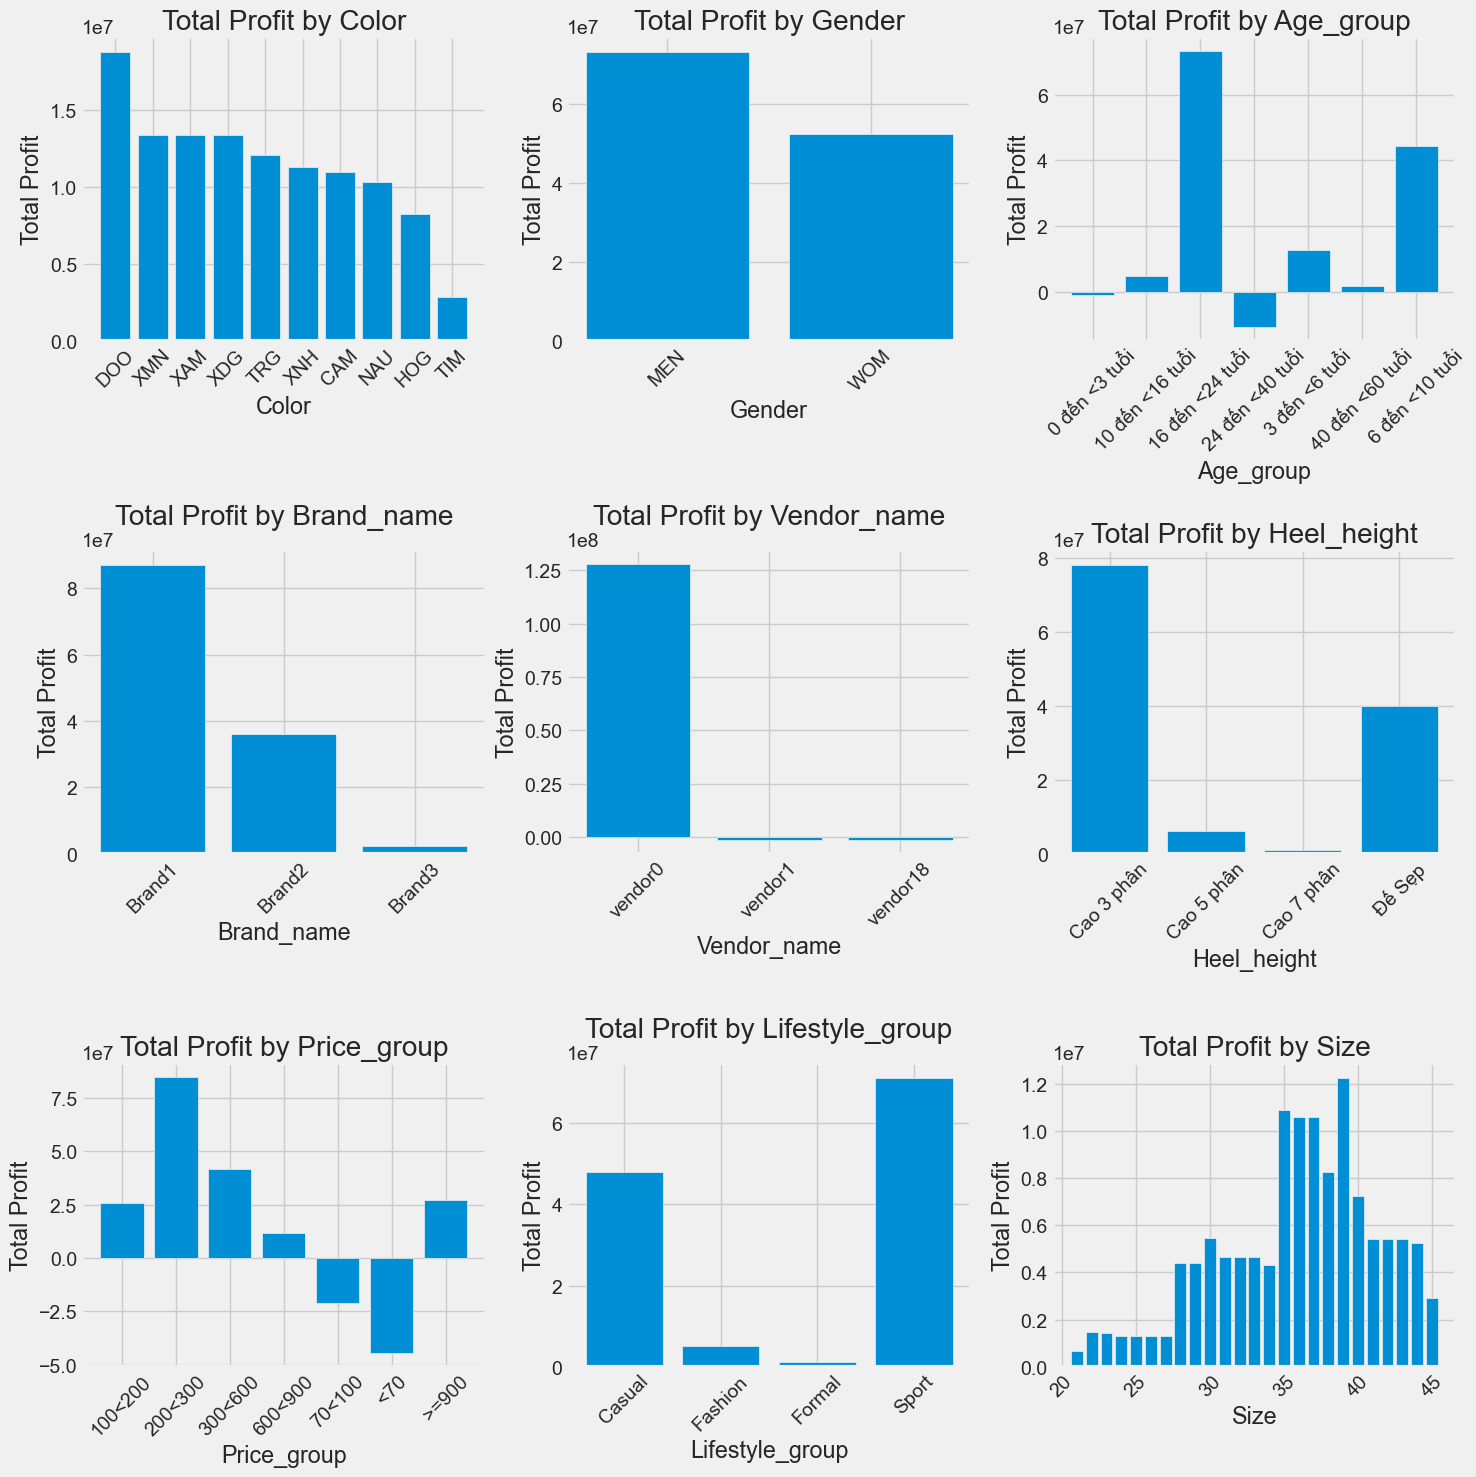

In [ ]:
categorical_variables = ['color', 'gender', 'age_group', 'brand_name', 'vendor_name', 'heel_height', 'price_group', 'lifestyle_group', 'size']

fig, axs = plt.subplots(3, 3, figsize=(15, 15))

# Plotting bar charts for each categorical variable
for i, variable in enumerate(categorical_variables):
    grouped_data = product_detail_df.groupby(variable)['profit'].sum().reset_index()

    # If the current variable is 'color', select only the top 5 colors with the highest profit
    if variable == 'color':
        grouped_data = grouped_data.sort_values('profit', ascending=False).head(10)

    ax = axs[i//3, i%3]
    ax.bar(grouped_data[variable], grouped_data['profit'])
    ax.set_xlabel(variable.capitalize())
    ax.set_ylabel('Total Profit')
    ax.set_title(f'Total Profit by {variable.capitalize()}')
    ax.tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability

plt.tight_layout()
plt.show()

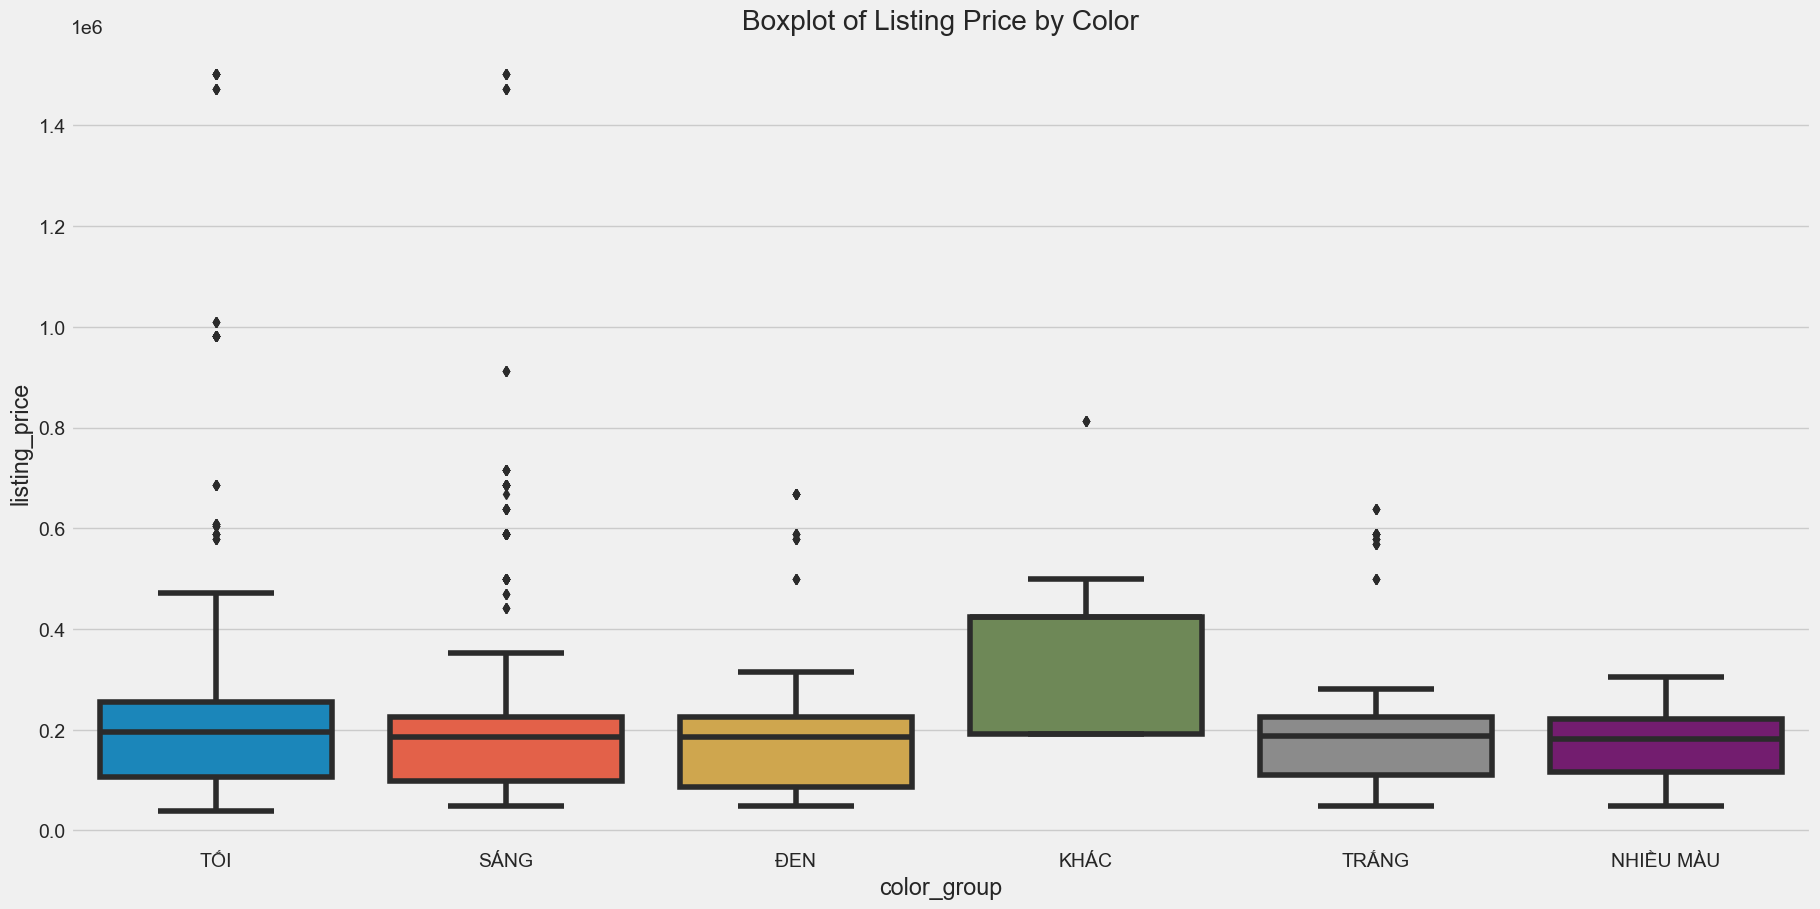

In [ ]:
plt.figure(figsize=(20, 10))
sns.boxplot(x='color_group', y='listing_price', data=product_detail_df)
plt.title('Boxplot of Listing Price by Color')
plt.show()

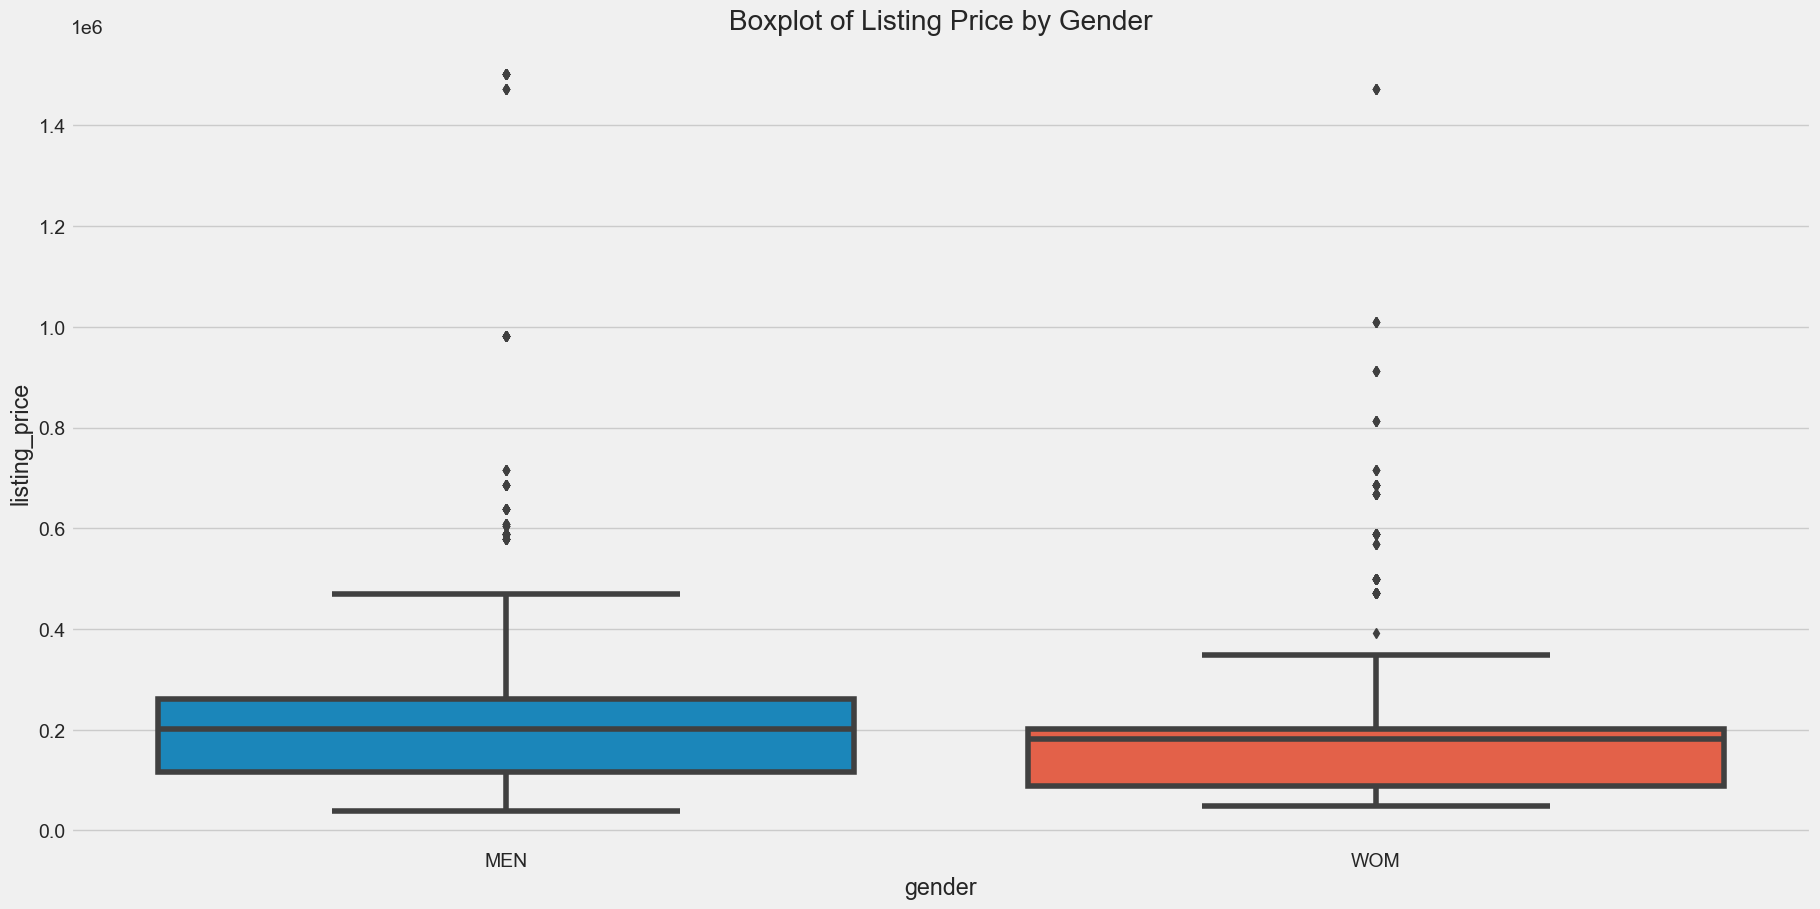

In [ ]:
plt.figure(figsize=(20, 10))
sns.boxplot(x='gender', y='listing_price', data=product_detail_df)
plt.title('Boxplot of Listing Price by Gender')
plt.show()

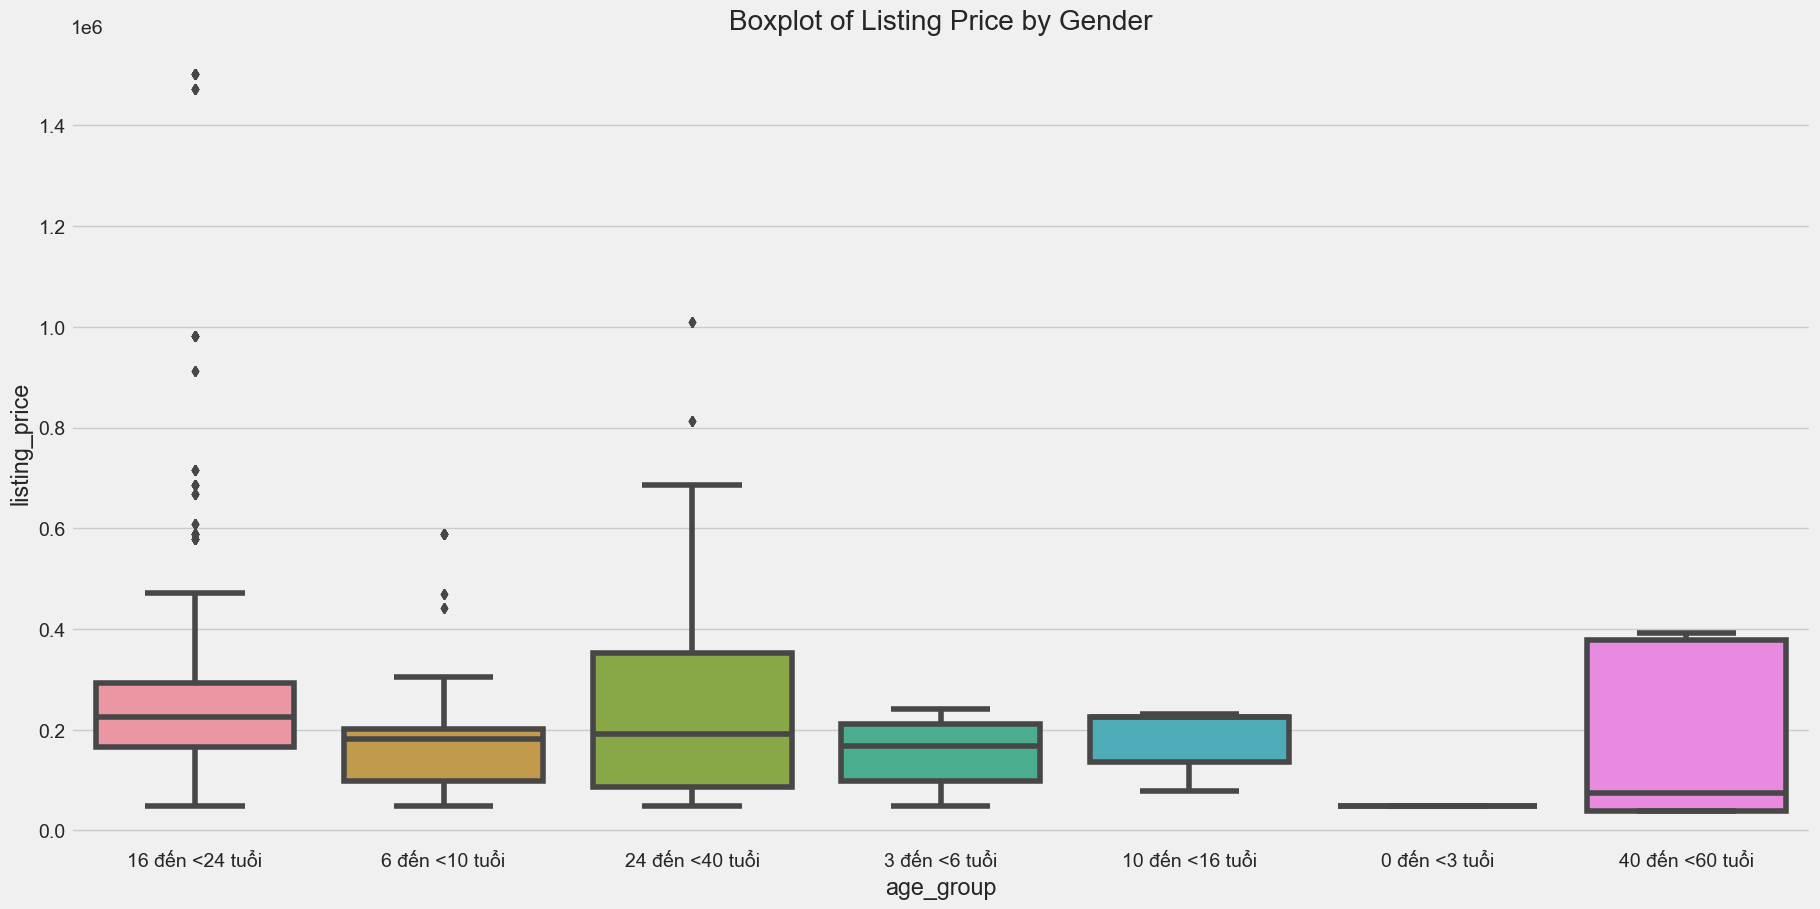

In [ ]:
plt.figure(figsize=(20, 10))
sns.boxplot(x='age_group', y='listing_price', data=product_detail_df)
plt.title('Boxplot of Listing Price by Gender')
plt.show()

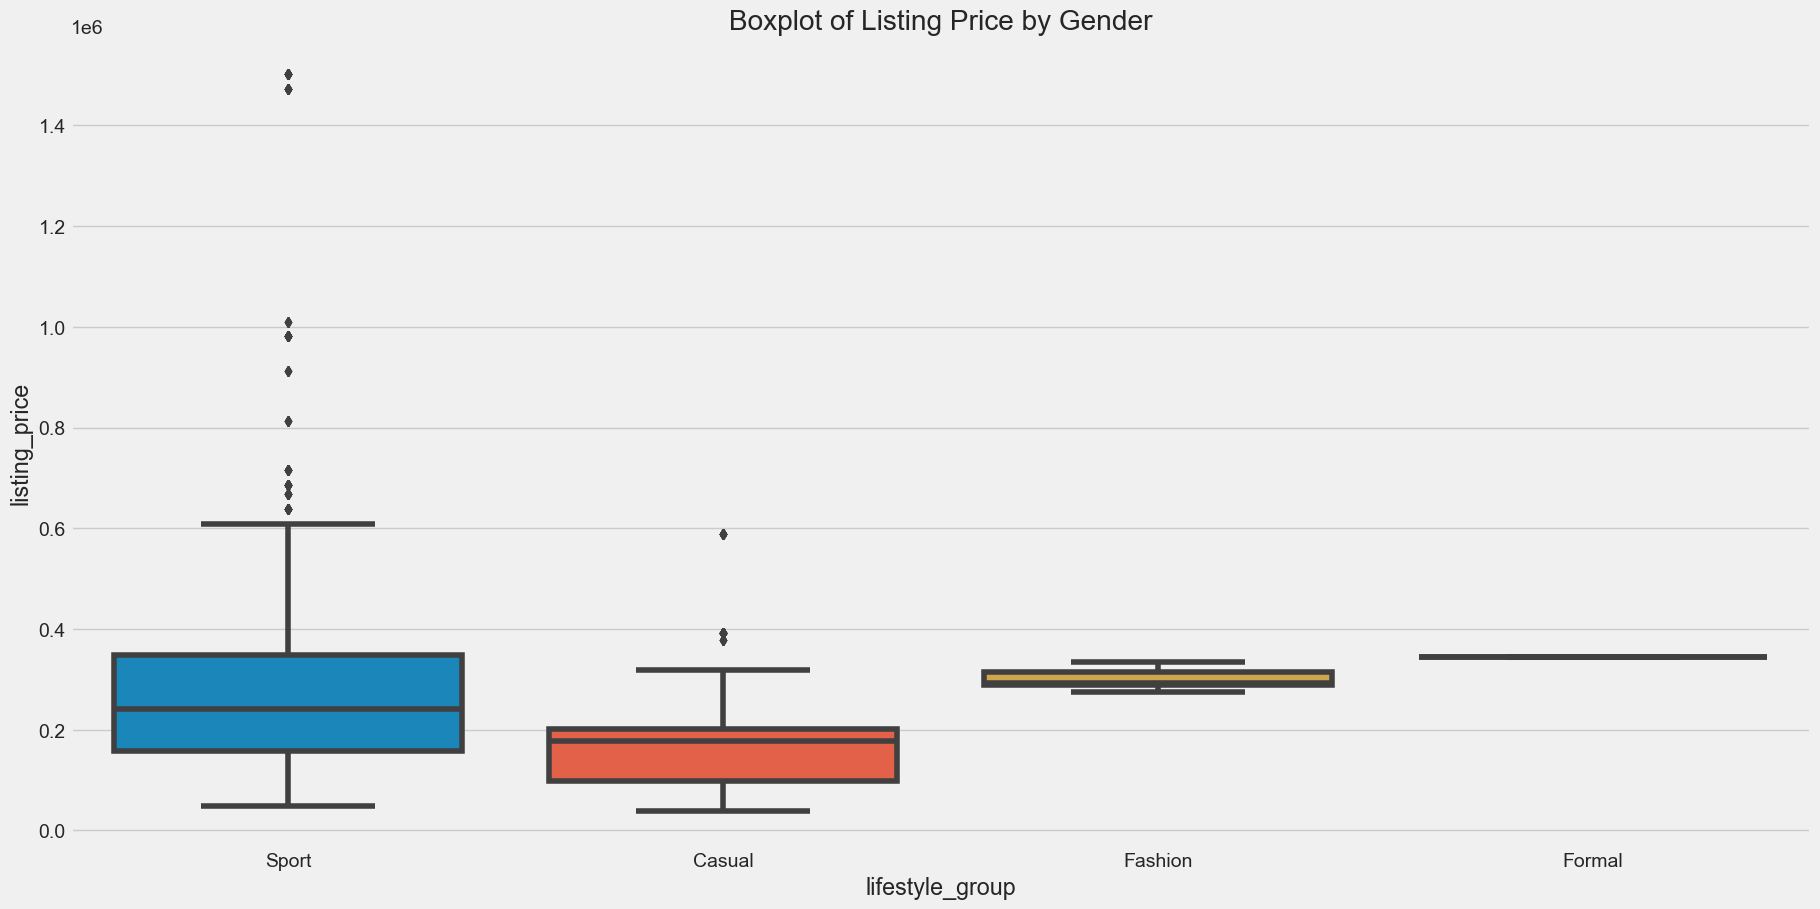

In [ ]:
plt.figure(figsize=(20, 10))
sns.boxplot(x='lifestyle_group', y='listing_price', data=product_detail_df)
plt.title('Boxplot of Listing Price by Gender')
plt.show()

In [ ]:


X = pd.get_dummies(product_detail_df[categorical_variables], drop_first=True)
y = product_detail_df['listing_price']

# Apply MinMaxScaler to X
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

# Apply MinMaxScaler to y
y = y.values.reshape(-1, 1)  # reshape to 2D array as required by the scaler
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Fit a Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

# Feature Importance
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': model.feature_importances_})
print(feature_importance.sort_values(by='Importance', ascending=False))


Mean Squared Error: 0.0009388634283957049
                      Feature    Importance
53          price_group_>=900  3.665564e-01
49        price_group_300<600  2.054704e-01
50        price_group_600<900  1.233445e-01
41          brand_name_Brand2  1.009709e-01
48        price_group_200<300  9.003143e-02
52            price_group_<70  3.103022e-02
51         price_group_70<100  2.034689e-02
0                        size  1.722083e-02
6                   color_DOO  4.552219e-03
56      lifestyle_group_Sport  4.257835e-03
33                  color_XNH  3.622251e-03
34                 gender_WOM  2.812100e-03
25                  color_XAM  2.699876e-03
45     heel_height_Cao 5 phân  2.528076e-03
37  age_group_24 đến <40 tuổi  2.501258e-03
47         heel_height_Đế Sẹp  2.316916e-03
19                  color_TRG  2.208895e-03
42          brand_name_Brand3  2.173928e-03
40   age_group_6 đến <10 tuổi  1.927447e-03
21                  color_VAG  1.914716e-03
54    lifestyle_group_Fashion  1.5

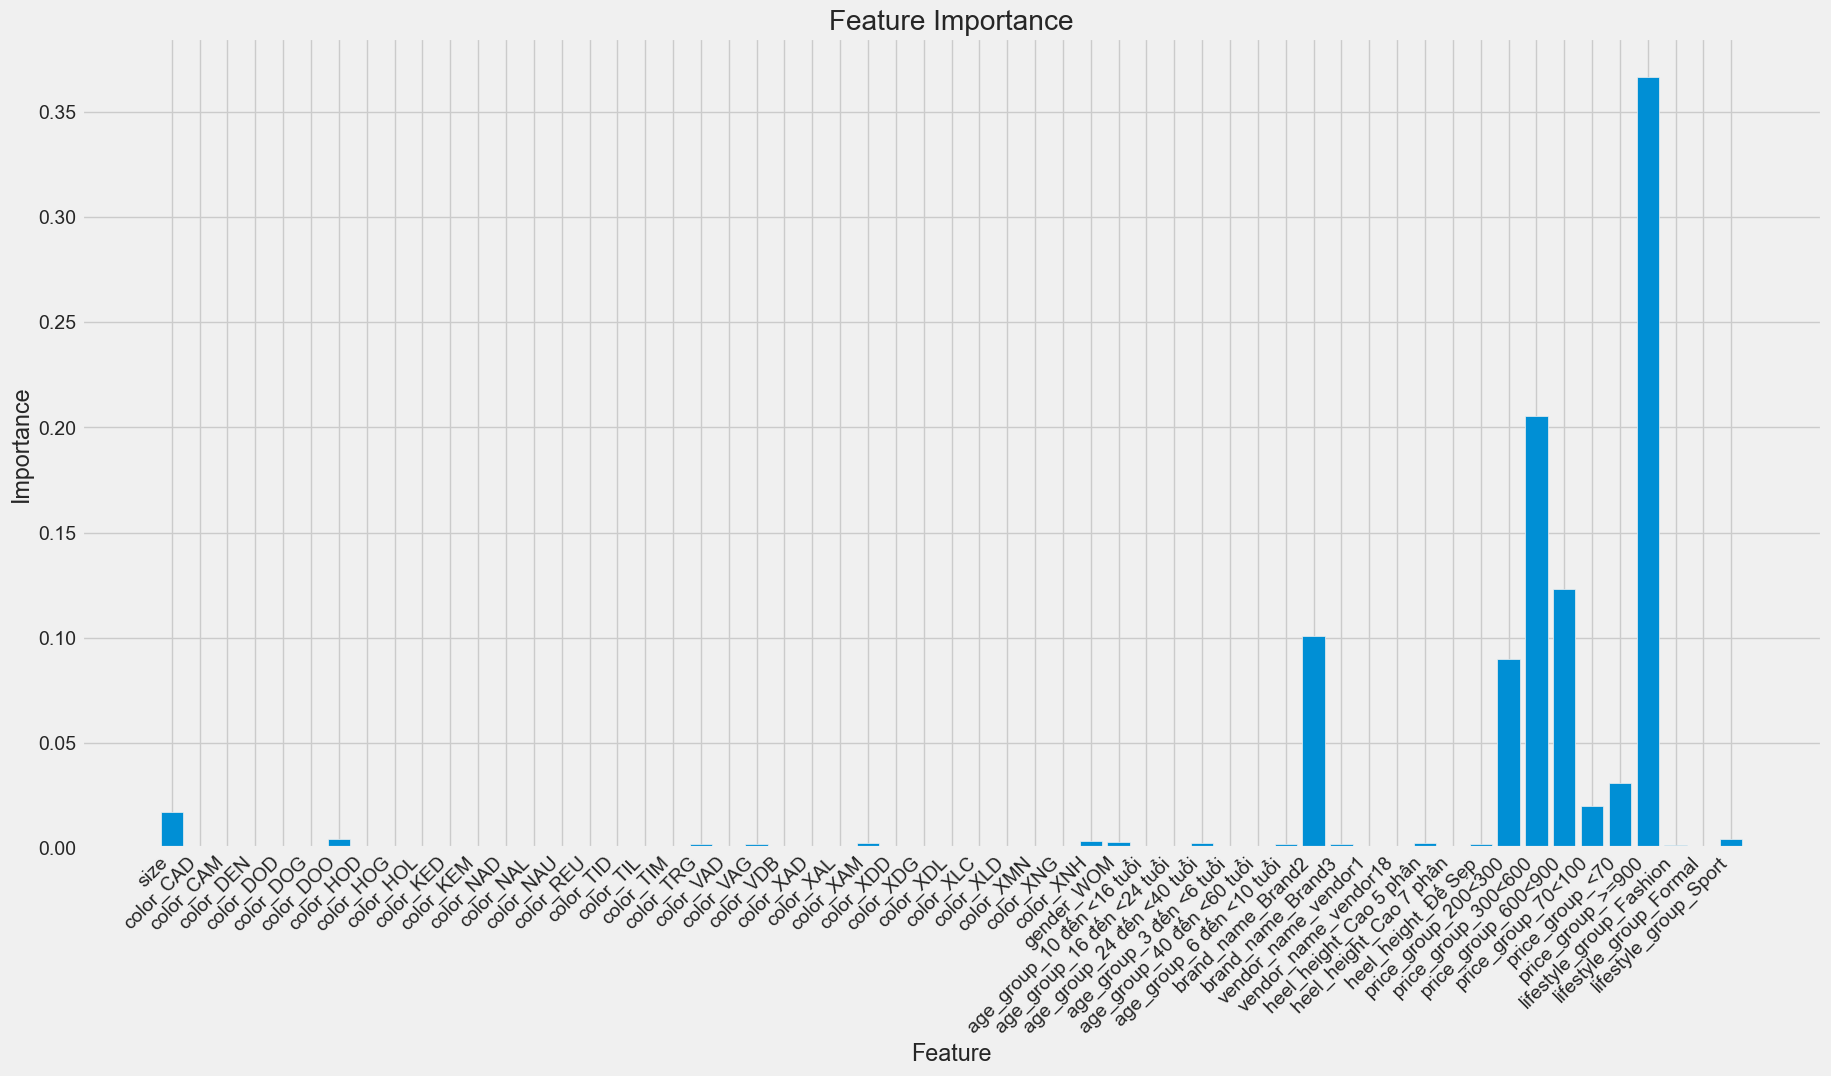

In [ ]:
plt.figure(figsize=(20, 10))
plt.bar(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
import re

X = pd.get_dummies(product_detail_df[categorical_variables], drop_first=True)
y = product_detail_df['listing_price']

# Convert feature names to string and remove invalid characters
X.columns = X.columns.astype(str)
X.columns = [re.sub(r'[\[\]<]', '', col) for col in X.columns]
print(X.columns)

# Apply MinMaxScaler to X
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

# Apply MinMaxScaler to y
y = y.values.reshape(-1, 1)  # reshape to 2D array as required by the scaler
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Fit an XGBoost Regressor
model = XGBRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

# Feature Importance
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': model.feature_importances_})
print(feature_importance.sort_values(by='Importance', ascending=False))

Mean Squared Error: 0.001073307159530449
                     Feature  Importance
53         price_group_>=900    0.614946
50        price_group_600900    0.183151
49        price_group_300600    0.114588
48        price_group_200300    0.026368
52            price_group_70    0.015203
51         price_group_70100    0.010221
54   lifestyle_group_Fashion    0.004791
41         brand_name_Brand2    0.003331
18                 color_TIM    0.002671
40   age_group_6 đến 10 tuổi    0.002584
42         brand_name_Brand3    0.002491
31                 color_XMN    0.002184
19                 color_TRG    0.001610
56     lifestyle_group_Sport    0.001588
45    heel_height_Cao 5 phân    0.001346
14                 color_NAU    0.001307
37  age_group_24 đến 40 tuổi    0.001294
25                 color_XAM    0.001135
21                 color_VAG    0.001117
33                 color_XNH    0.001103
34                gender_WOM    0.000706
35  age_group_10 đến 16 tuổi    0.000636
27              

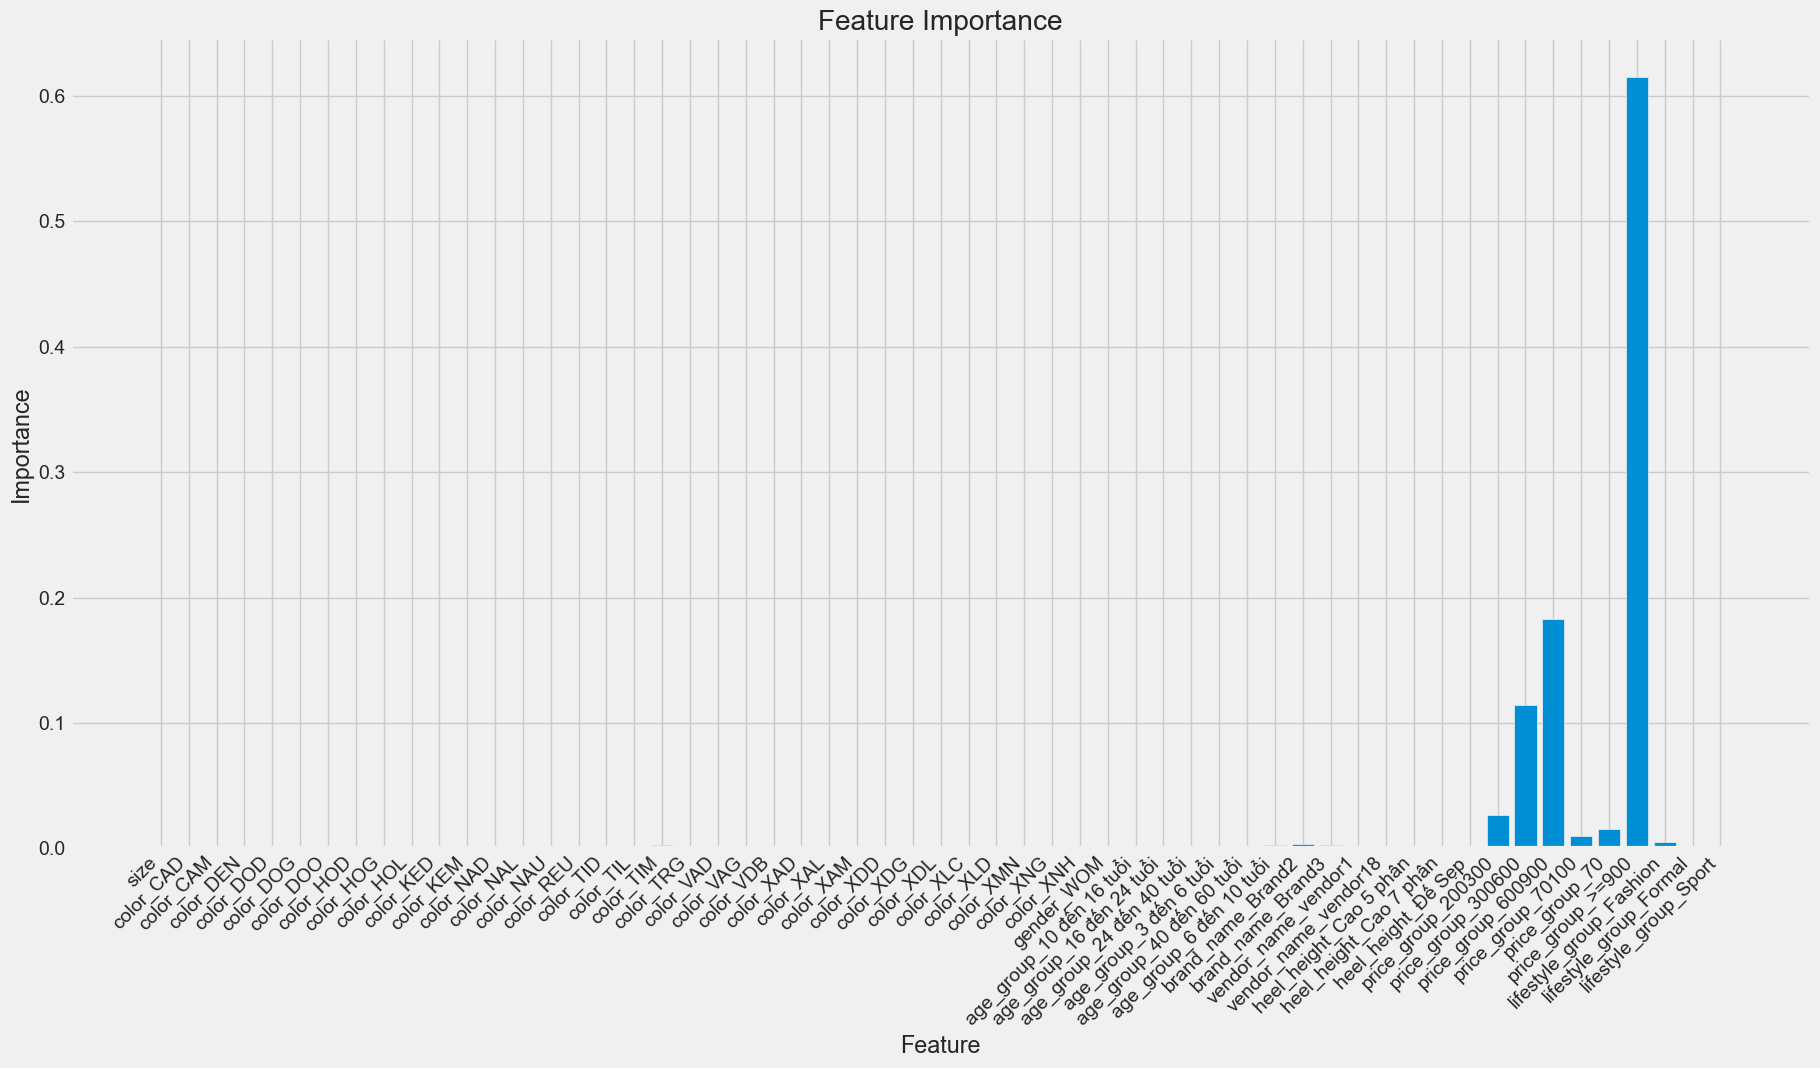

In [ ]:
plt.figure(figsize=(20, 10))
plt.bar(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
merged_df = sales_data.merge(product_detail_df, on='product_id', how='inner')

In [ ]:
merged_df

site  branch_id channel_id distribution_channel  \
0        1800       1800     Online               Online   
1        1803       1800       CHTT               Bán lẻ   
2        1236       1200       CHTT               Bán lẻ   
3        1800       1800     Online               Online   
4        1800       1800     Online               Online   
...       ...        ...        ...                  ...   
2442455  1300       1300       TGPP             Hợp đồng   
2442456  1259       1200       CHTT               Bán lẻ   
2442457  1300       1300       TGPP             Hợp đồng   
2442458  1300       1300       TGPP             Hợp đồng   
2442459  1257       1200       CHTT               Bán lẻ   

        distribution_channel_code  sold_quantity  cost_price_x  net_price  \
0                             ZF2              3       3465960    4816665   
1                              FP              1       1155320    1699000   
2                              FP              1       1155320    1699000   
3                              FP              1       1155320    1599000   
4                              FP              4       4621280    6696000   
...                           ...            ...           ...        ...   
2442455                       ZF1             36       4822560    5274101   
2442456                        FP              1         52744      70000   
2442457                       ZF1             18       2496960    2747943   
2442458                       ZF1             36       4993920    5495886   
2442459                        FP              1         79773      86000   

        customer_id                             product_id  ...  \
0         02757bde1  aa01577e94a049c395087645063c5275NAU42  ...   
1         f00886420  aa01577e94a049c395087645063c5275NAU42  ...   
2         68ec2df45  aa01577e94a049c395087645063c5275NAU42  ...   
3         5143d0eee  aa01577e94a049c395087645063c5275NAU42  ...   
4         5143d0eee  aa01577e94a049c395087645063c5275NAU42  ...   
...             ...                                    ...  ...   
2442455   61862a621  550d442e9c84473a88f72ef85ad525b4XNH37  ...   
2442456   9a0343b4f  08e0e59e8e204c9b8e9cb9966ee608a2XAM35  ...   
2442457   2044ef484  f0c027a6715144e783df8c70ae90862aDEN35  ...   
2442458   2044ef484  f3bd68a22a494e40ba049f9bdcefa857DEN36  ...   
2442459   6c31dde16  ca261cf5500b47508539f44eb0bd0cabDOD32  ...   

            mch_description code_lock       option  cost_price_y  \
0        NHÓM GÌAY THỂ THAO       NaN  P06-C05-L**     1155320.0   
1        NHÓM GÌAY THỂ THAO       NaN  P06-C05-L**     1155320.0   
2        NHÓM GÌAY THỂ THAO       NaN  P06-C05-L**     1155320.0   
3        NHÓM GÌAY THỂ THAO       NaN  P06-C05-L**     1155320.0   
4        NHÓM GÌAY THỂ THAO       NaN  P06-C05-L**     1155320.0   
...                     ...       ...          ...           ...   
2442455            NHÓM XỐP       NaN      P02-C05      133960.0   
2442456      NHÓM HÀNG CHẬM       NaN      P01-C04       53720.0   
2442457            NHÓM XỐP       NaN      P03-C02      138720.0   
2442458            NHÓM XỐP       NaN      P03-C02      138720.0   
2442459      NHÓM HÀNG CHẬM         x      P**-C03       85000.0   

                          product_syle_color  \
0        aa01577e94a049c395087645063c5275NAU   
1        aa01577e94a049c395087645063c5275NAU   
2        aa01577e94a049c395087645063c5275NAU   
3        aa01577e94a049c395087645063c5275NAU   
4        aa01577e94a049c395087645063c5275NAU   
...                                      ...   
2442455  550d442e9c84473a88f72ef85ad525b4XNH   
2442456  08e0e59e8e204c9b8e9cb9966ee608a2XAM   
2442457  f0c027a6715144e783df8c70ae90862aDEN   
2442458  f3bd68a22a494e40ba049f9bdcefa857DEN   
2442459  ca261cf5500b47508539f44eb0bd0cabDOD   

                             product_syle  brand_name vendor_name  profit_y  \
0        aa01577e94a049c395087645063c5275      Brand2     vendor0  512789.0   
1     

In [ ]:
merged_df['profit'] = (merged_df['sold_quantity'] >= 0).mul(merged_df['total_sales']) - merged_df['total_cost']


In [ ]:
merged_df['profit'].value_counts()

profit
 59200       21399
 86400       20069
 146549      19258
 55164       15064
 58487       14237
             ...  
 45340           1
-306320          1
 426080          1
 33066           1
 18070776        1
Name: count, Length: 51818, dtype: int64

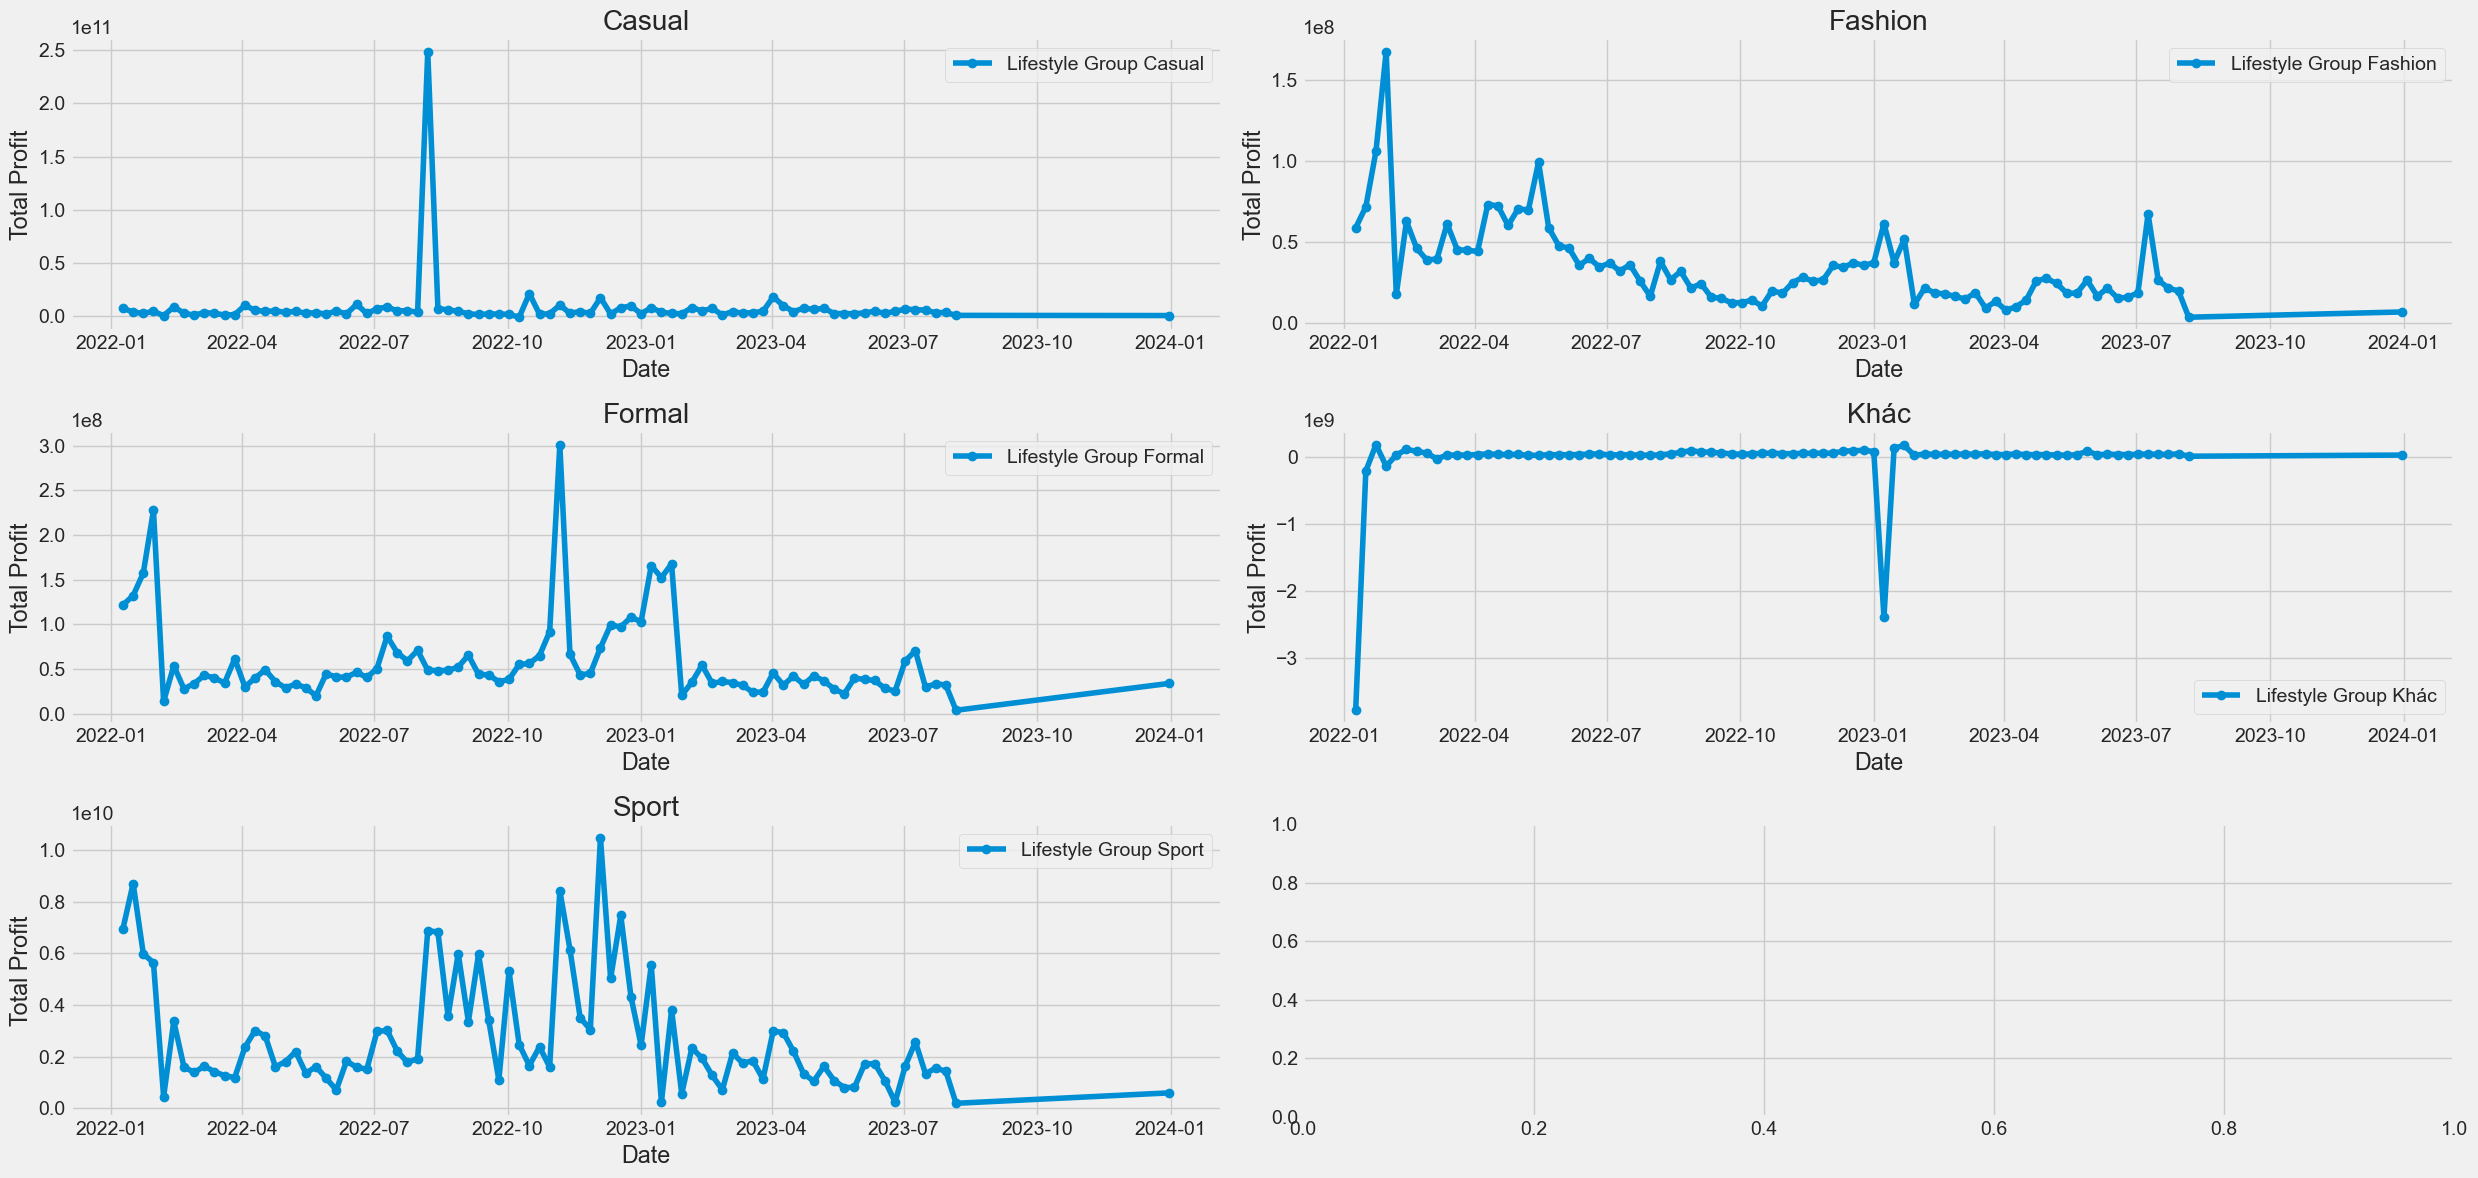

In [ ]:
total_profit_over_time = merged_df.groupby(['date', 'lifestyle_group'])['profit'].sum().reset_index()

# Get unique lifestyle groups
lifestyle_groups = total_profit_over_time['lifestyle_group'].unique()

# Create subplots in a 3x2 grid
fig, axs = plt.subplots(3, 2, figsize=(25, 12))
axs = axs.ravel()

# Plot a line for each lifestyle_group
for i, group in enumerate(lifestyle_groups):
    data = total_profit_over_time[total_profit_over_time['lifestyle_group'] == group]
    axs[i].plot(data['date'], data['profit'], marker='o', label=f'Lifestyle Group {group}')
    axs[i].set_title(f'{group}')
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('Total Profit')
    axs[i].grid(True)
    axs[i].legend()

plt.tight_layout()
plt.show()  

2/2 [==============================] - 0s 12ms/step
Group Casual Test Mean Squared Error: 7.941704260608583e-05
2/2 [==============================] - 0s 7ms/step
Group Fashion Test Mean Squared Error: 0.0027325287493930395
2/2 [==============================] - 0s 6ms/step
Group Formal Test Mean Squared Error: 0.00023789398843296775
2/2 [==============================] - 0s 4ms/step
Group Khác Test Mean Squared Error: 0.0009119724033423458
2/2 [==============================] - 0s 9ms/step
Group Sport Test Mean Squared Error: 0.00023332839381394417


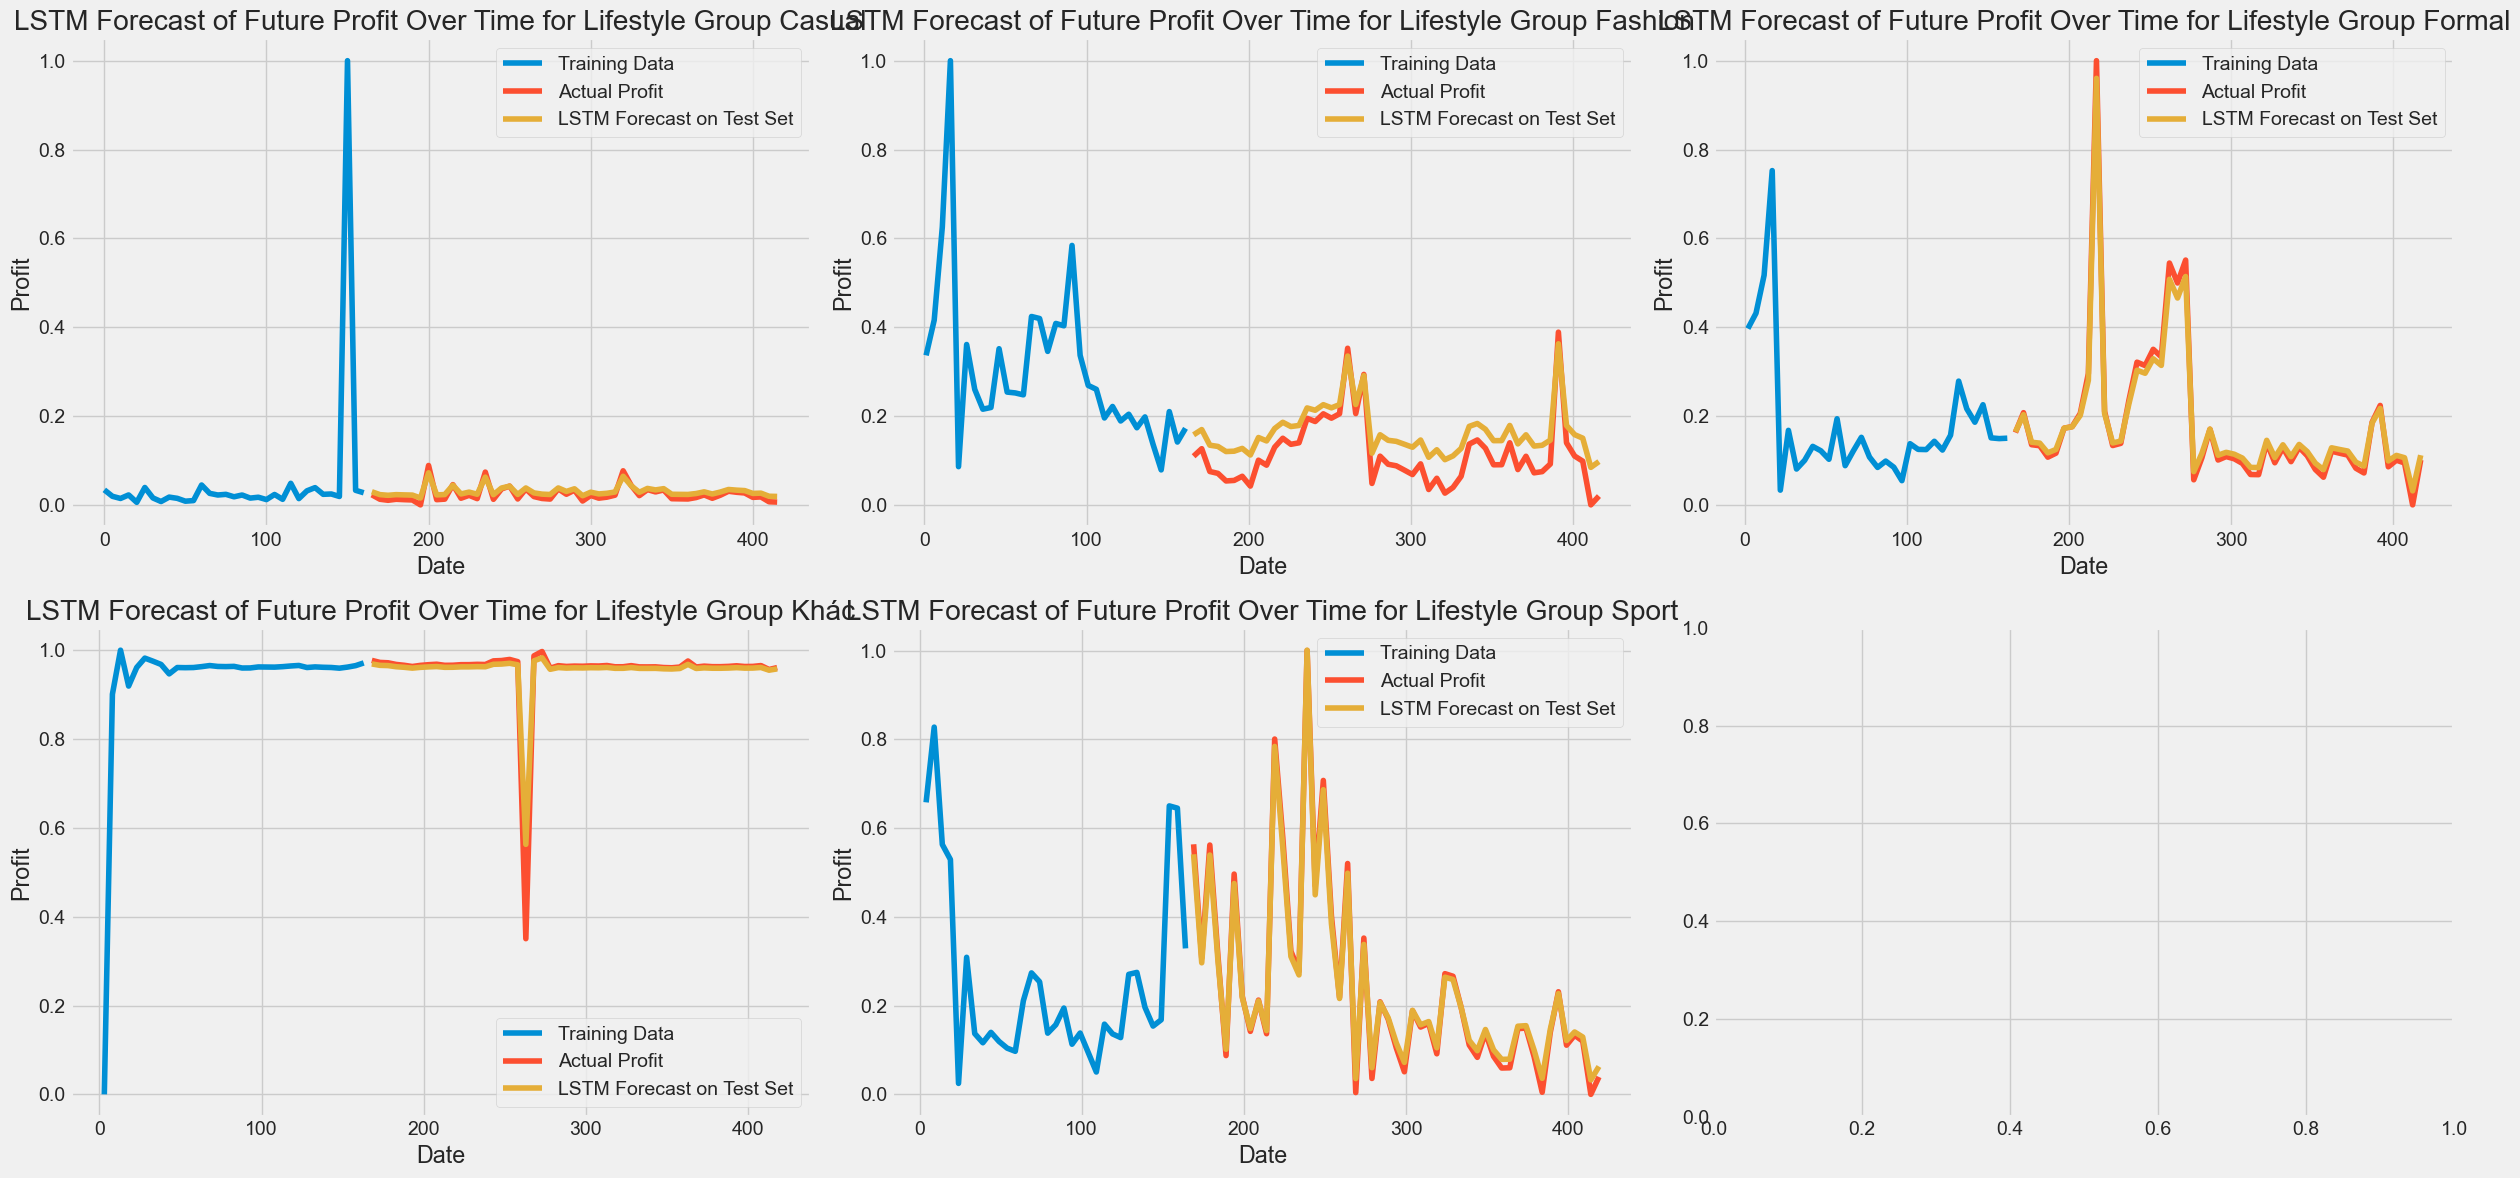

In [ ]:
total_profit_over_time = merged_df.groupby(['date', 'lifestyle_group'])['profit'].sum().reset_index()
scaler = MinMaxScaler()

fig, axs = plt.subplots(2, 3, figsize=(25, 12))
axs = axs.ravel()

# Loop over each unique lifestyle_group
for i, group in enumerate(total_profit_over_time['lifestyle_group'].unique()):
    data = total_profit_over_time[total_profit_over_time['lifestyle_group'] == group]
    data['profit'] = scaler.fit_transform(data[['profit']])

    # Split the data into training and testing sets
    train_size = int(len(data) * 0.4)
    train, test = data[:train_size], data[train_size:]

    # Reshape the data to be 3D, as expected by the LSTM layer
    train_values = np.array(train['profit']).reshape(-1, 1, 1)
    test_values = np.array(test['profit']).reshape(-1, 1, 1)

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(500, activation='relu', input_shape=(1, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Fit the model on the training set
    model.fit(train_values, train['profit'], epochs=200, verbose=0)

    # Forecast future values on the test set
    forecast_values_test = model.predict(test_values)

    # Evaluate the model on the test set
    mse_test = mean_squared_error(test['profit'], forecast_values_test)
    print(f'Group {group} Test Mean Squared Error: {mse_test}')

    # Visualize the results
    axs[i].plot(train.index, train['profit'], label='Training Data')
    axs[i].plot(test.index, test['profit'], label='Actual Profit')
    axs[i].plot(test.index, forecast_values_test, label='LSTM Forecast on Test Set')
    axs[i].set_title(f'Future Profit Over Time for Lifestyle Group {group}')
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('Profit')
    axs[i].legend()

plt.tight_layout()
plt.show()

2/2 [==============================] - 0s 10ms/step
Product DEP Test Mean Squared Error: 3.4491218624638717e-06
2/2 [==============================] - 0s 10ms/step
Product GIA Test Mean Squared Error: 6.98944154332179e-05
2/2 [==============================] - 0s 8ms/step
Product PKI Test Mean Squared Error: 0.0005650049678732151
2/2 [==============================] - 0s 5ms/step
Product SAN Test Mean Squared Error: 0.0001200886956043447
2/2 [==============================] - 3s 9ms/step
Product TBL Test Mean Squared Error: 0.020287007178721624


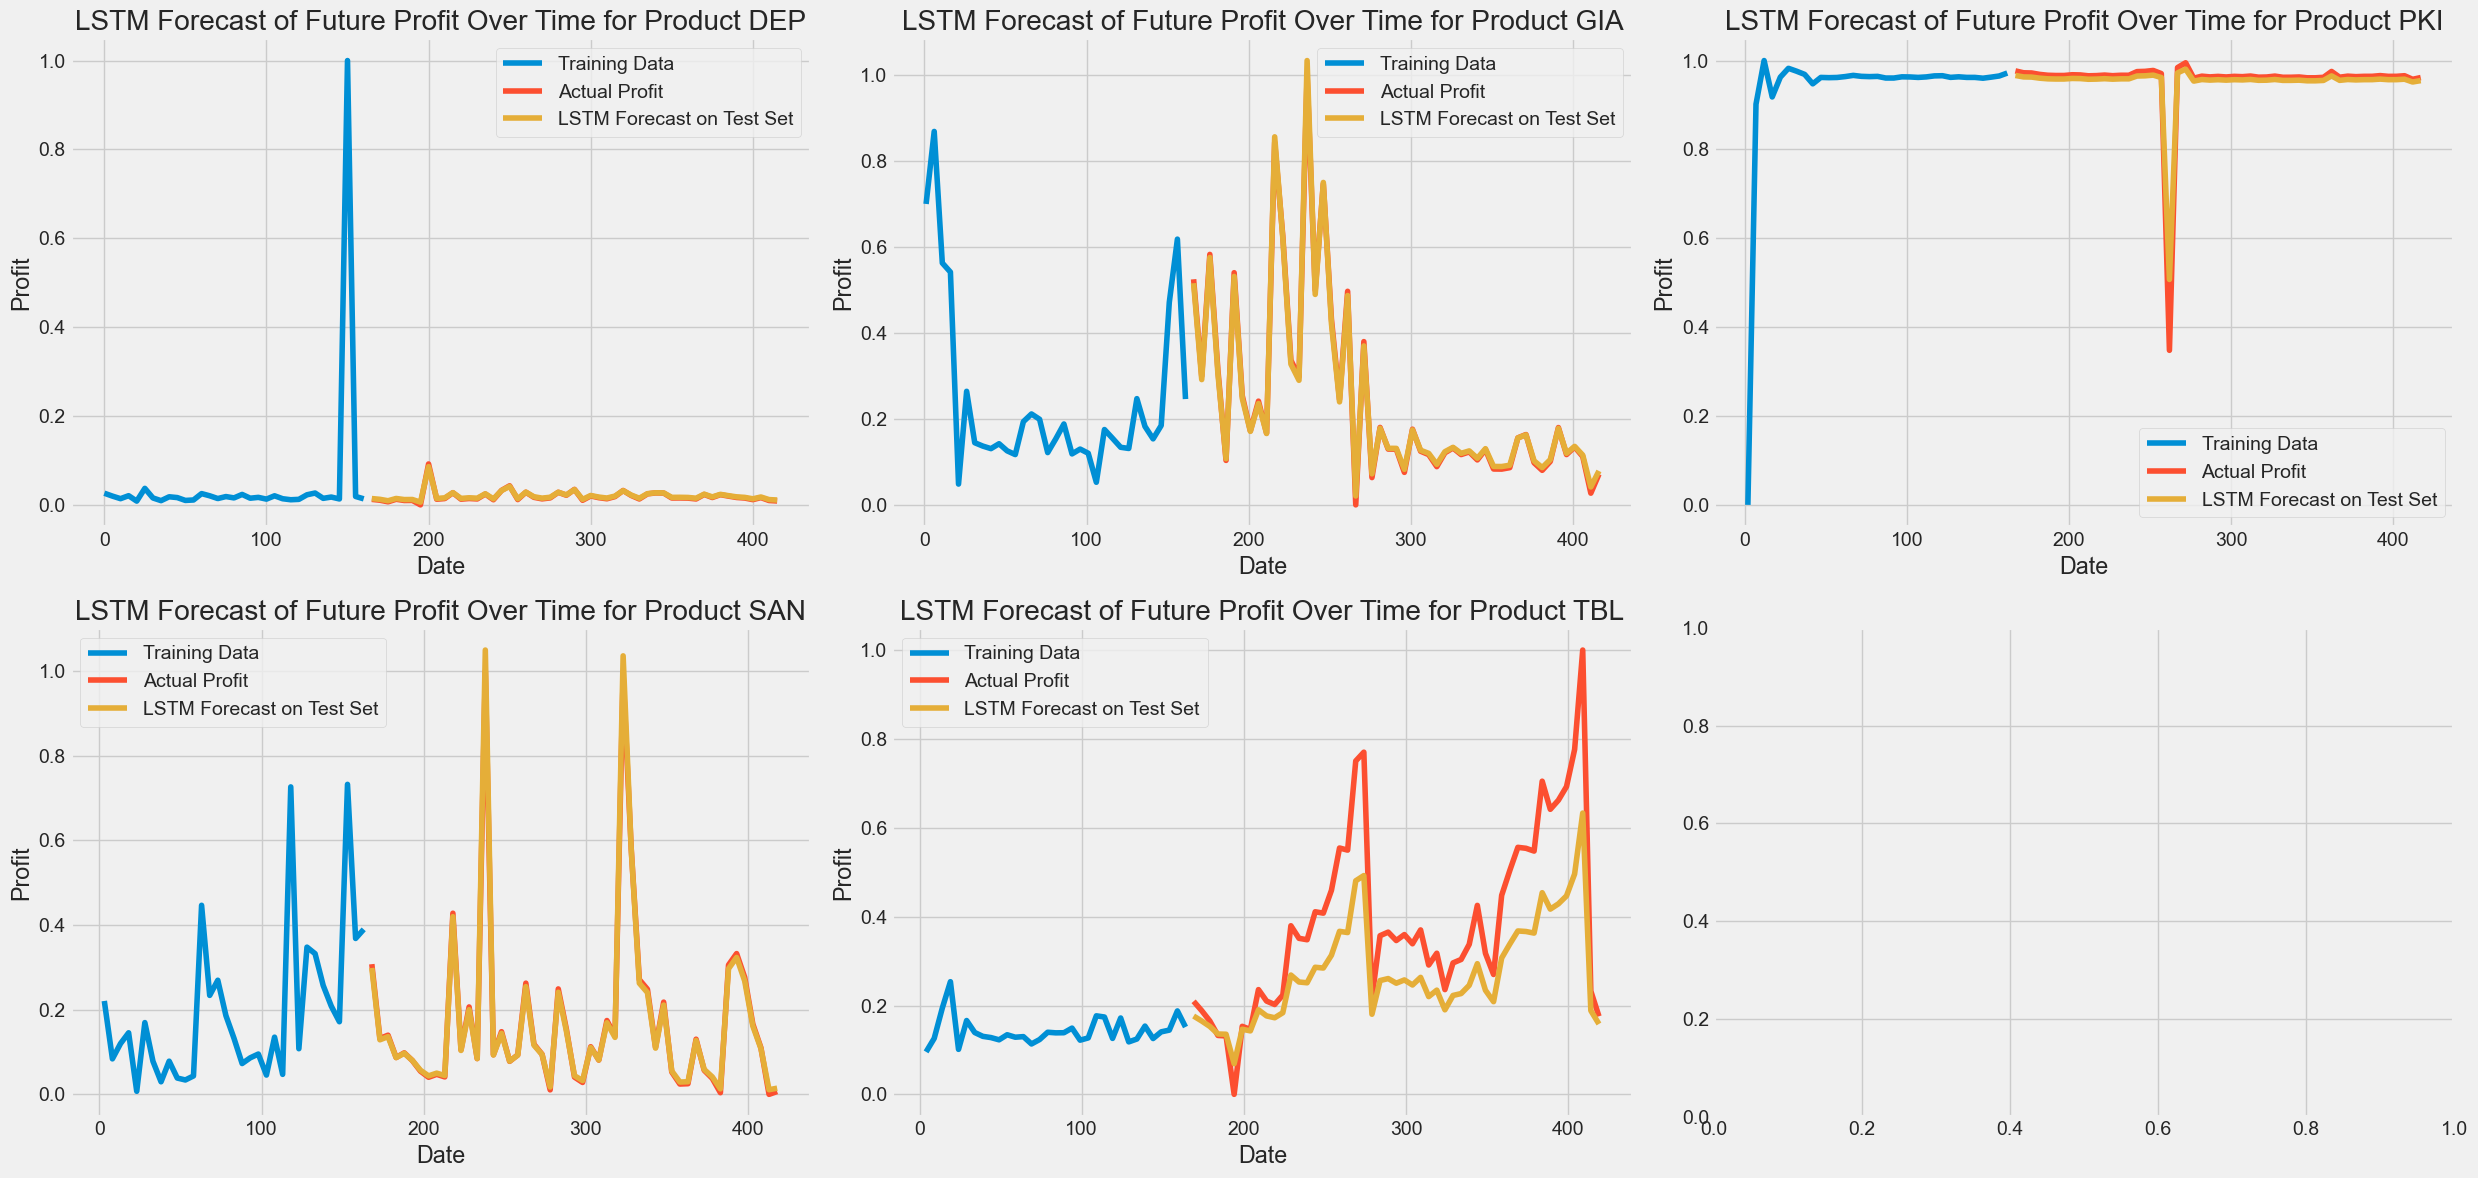

In [ ]:
total_profit_over_time = merged_df.groupby(['date', 'product_group'])['profit'].sum().reset_index()
scaler = MinMaxScaler()

fig, axs = plt.subplots(2, 3, figsize=(25, 12))
axs = axs.ravel()

# Loop over each unique lifestyle_group
for i, product in enumerate(total_profit_over_time['product_group'].unique()):
    data = total_profit_over_time[total_profit_over_time['product_group'] == product]
    data['profit'] = scaler.fit_transform(data[['profit']])

    # Split the data into training and testing sets
    train_size = int(len(data) * 0.4)
    train, test = data[:train_size], data[train_size:]

    # Reshape the data to be 3D, as expected by the LSTM layer
    train_values = np.array(train['profit']).reshape(-1, 1, 1)
    test_values = np.array(test['profit']).reshape(-1, 1, 1)

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(500, activation='relu', input_shape=(1, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Fit the model on the training set
    model.fit(train_values, train['profit'], epochs=300, verbose=0)

    # Forecast future values on the test set
    forecast_values_test = model.predict(test_values)

    # Evaluate the model on the test set
    mse_test = mean_squared_error(test['profit'], forecast_values_test)
    print(f'Product {product} Test Mean Squared Error: {mse_test}')

    # Visualize the results
    axs[i].plot(train.index, train['profit'], label='Training Data')
    axs[i].plot(test.index, test['profit'], label='Actual Profit')
    axs[i].plot(test.index, forecast_values_test, label='LSTM Forecast on Test Set')
    axs[i].set_title(f'Future Profit Over Time for Product {product}')
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('Profit')
    axs[i].legend()

plt.tight_layout()
plt.show()